In [1]:
%%capture
!pip install adjustText jinja2 scipy statsmodels openpyxl

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from adjustText import adjust_text
from scipy import stats
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from src.dataset import read_dataset, split_train_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
OUTPUT_FOLDER = "outputs/paper"

## 1. Datasets Overview

In [5]:
DATASETS_FOLDER = "datasets"

In [6]:
def print_dataset_summary(df, keep_cols):
    n_rows = len(df)
    print(f"Number of instances: {n_rows}")
    print(f"Time period: {str(df['ds'].iloc[0])} - {str(df['ds'].iloc[n_rows-1])}")
    n_rows_missing = df[keep_cols].isnull().any(axis=1).sum()
    perc_rows_missing = round(n_rows_missing / n_rows * 100, 2)
    print(f"Number of rows with at least one missing value: {n_rows_missing} ({perc_rows_missing})%")

In [7]:
def check_adf(series, name):
    result = adfuller(series)
    print(f"\nADF Test for {name}:")
    print(f"  Test Statistic: {result[0]:.20f}")
    formatted_pvalue = "{:.1e}".format(result[1])
    base, exponent = formatted_pvalue.split('e')
    formatted_pvalue = f"{base} x 10^{int(exponent)}"
    print(f"  p-value: {formatted_pvalue}")
    if result[1] < 0.05:
        print("  ✅ Likely stationary")
    else:
        print("  ❌ Likely non-stationary")

def get_seasonal_decomposition(df, variables):
    dominant_period = len(df)
    for variable in variables:
        frequencies, power = periodogram(df[variable])
        dominant_freq = frequencies[np.argmax(power[1:]) + 1]
        dominant_period_ = int(round(1 / dominant_freq))
        dominant_period = min(dominant_period_, dominant_period)
        print(f"Estimated dominant period for {variable}: {dominant_period_}")

    for variable in variables:
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        fig.suptitle(f'Time Series Analysis for {variable}', fontsize=14)
        # ACF
        plot_acf(df[variable], ax=axes[0], alpha=0.05)
        axes[0].set_title(f'ACF')
        # PACF
        plot_pacf(df[variable], ax=axes[1], alpha=0.05)
        axes[1].set_title(f'PACF')
        # Decomposition (trend, seasonal, residual)
        decomposition = seasonal_decompose(df[variable], model='additive', period=dominant_period)
        axes[2].plot(decomposition.trend, label='Trend')
        axes[2].plot(decomposition.seasonal, label='Seasonal')
        axes[2].plot(decomposition.resid, label='Residual')
        axes[2].set_title('Seasonal Decomposition')
        axes[2].legend()
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

### 1.1. Air Quality

In [8]:
database_name = "UCI"
dataset_name = "AIR_QUALITY"

In [9]:
df = pd.read_csv(f"{DATASETS_FOLDER}/{database_name.lower()}/{dataset_name.lower()}.csv")
keep_cols = ["ds", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)", "T", "RH"]

In [10]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
CO(GT): 82.01%
PT08.S1(CO): 96.09%
NMHC(GT): 9.769999999999996%
C6H6(GT): 96.09%
PT08.S2(NMHC): 96.09%
NOx(GT): 82.48%
PT08.S3(NOx): 96.09%
NO2(GT): 82.45%
PT08.S4(NO2): 96.09%
PT08.S5(O3): 96.09%
T: 96.09%
RH: 96.09%
AH: 96.09%


In [11]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)


Number of instances: 9357
Time period: 2004-03-10-18.00.00 - 2005-04-04-14.00.00
Number of rows with at least one missing value: 2416 (25.82)%


CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)        T       RH
count  7674.00   8991.00  7718.00  7715.00  8991.00  8991.00
mean      2.15     10.08   246.90   113.09    18.32    49.23
std       1.45      7.45   212.98    48.37     8.83    17.32
min       0.10      0.10     2.00     2.00    -1.90     9.20
25%       1.10      4.40    98.00    78.00    11.80    35.80
50%       1.80      8.20   180.00   109.00    17.80    49.60
75%       2.90     14.00   326.00   142.00    24.40    62.50
max      11.90     63.70  1479.00   340.00    44.60    88.70

In [12]:
df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

In [13]:
for variable in variables:
    check_adf(df[variable], variable)


ADF Test for CO(GT):
  Test Statistic: -9.06789251045169386600
  p-value: 4.4 x 10^-15
  ✅ Likely stationary

ADF Test for C6H6(GT):
  Test Statistic: -9.55946569008222368780
  p-value: 2.4 x 10^-16
  ✅ Likely stationary

ADF Test for NOx(GT):
  Test Statistic: -5.78433065645572330737
  p-value: 5.0 x 10^-7
  ✅ Likely stationary

ADF Test for NO2(GT):
  Test Statistic: -8.15357598098698055367
  p-value: 9.6 x 10^-13
  ✅ Likely stationary

ADF Test for T:
  Test Statistic: -2.99884592068515853924
  p-value: 3.5 x 10^-2
  ✅ Likely stationary

ADF Test for RH:
  Test Statistic: -6.50070898218241755018
  p-value: 1.2 x 10^-8
  ✅ Likely stationary


Estimated dominant period for CO(GT): 24
Estimated dominant period for C6H6(GT): 24
Estimated dominant period for NOx(GT): 7485
Estimated dominant period for NO2(GT): 24
Estimated dominant period for T: 7485
Estimated dominant period for RH: 7485


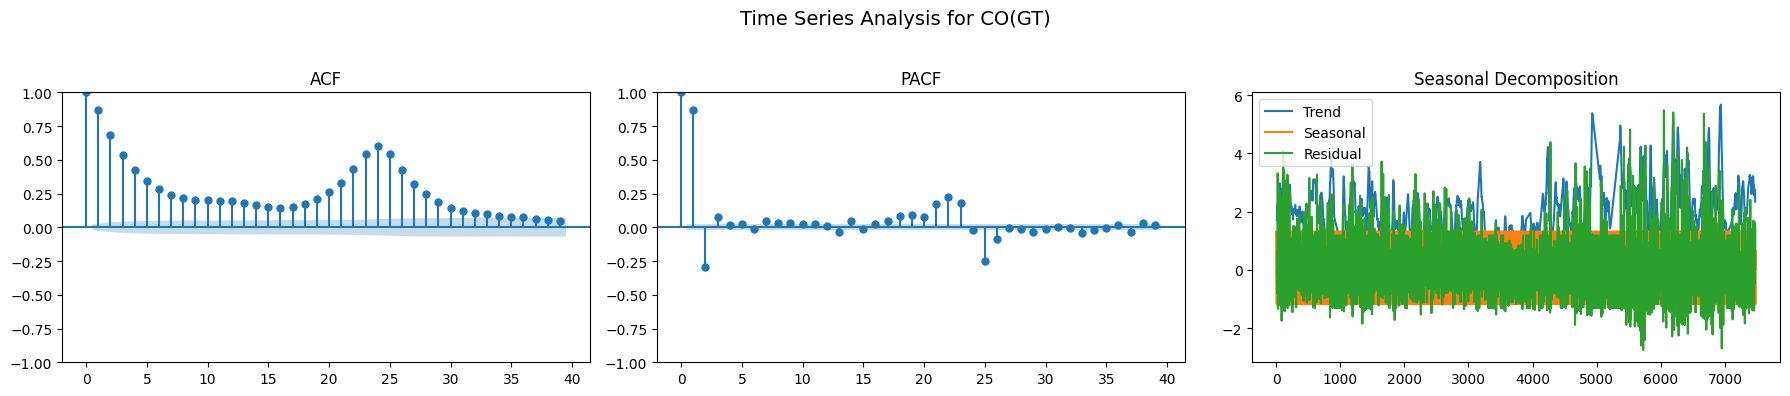

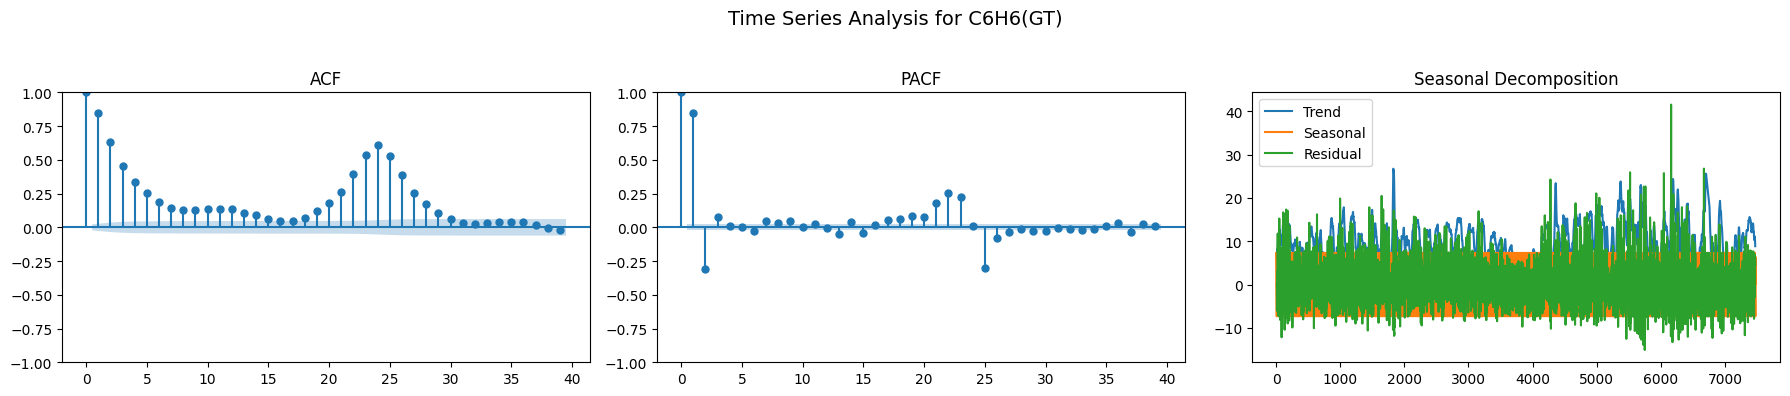

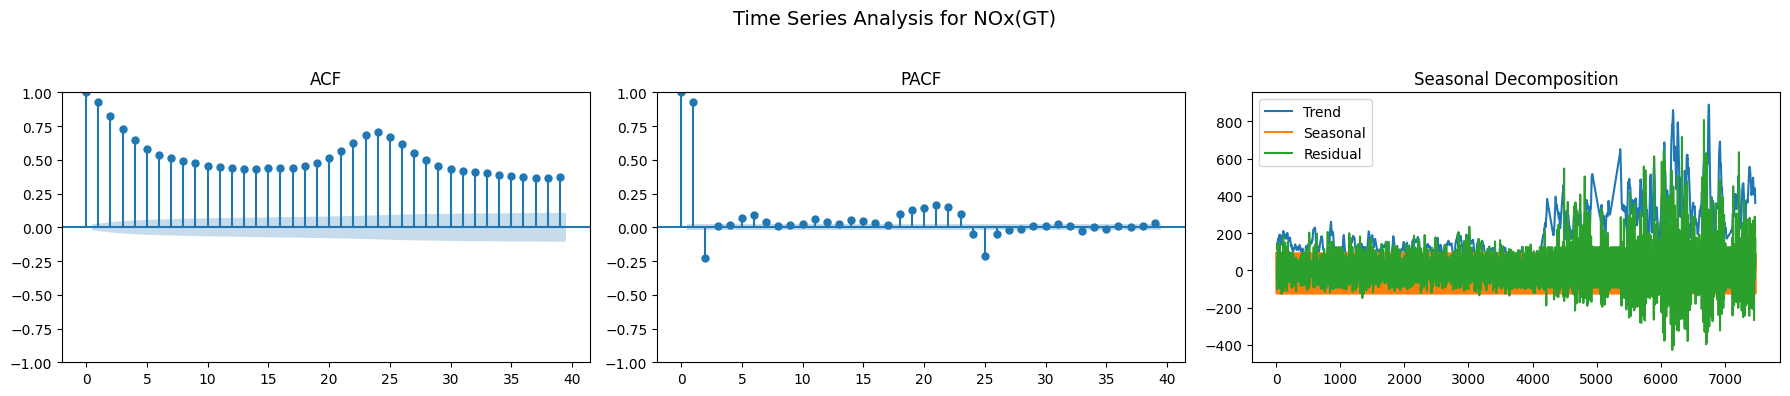

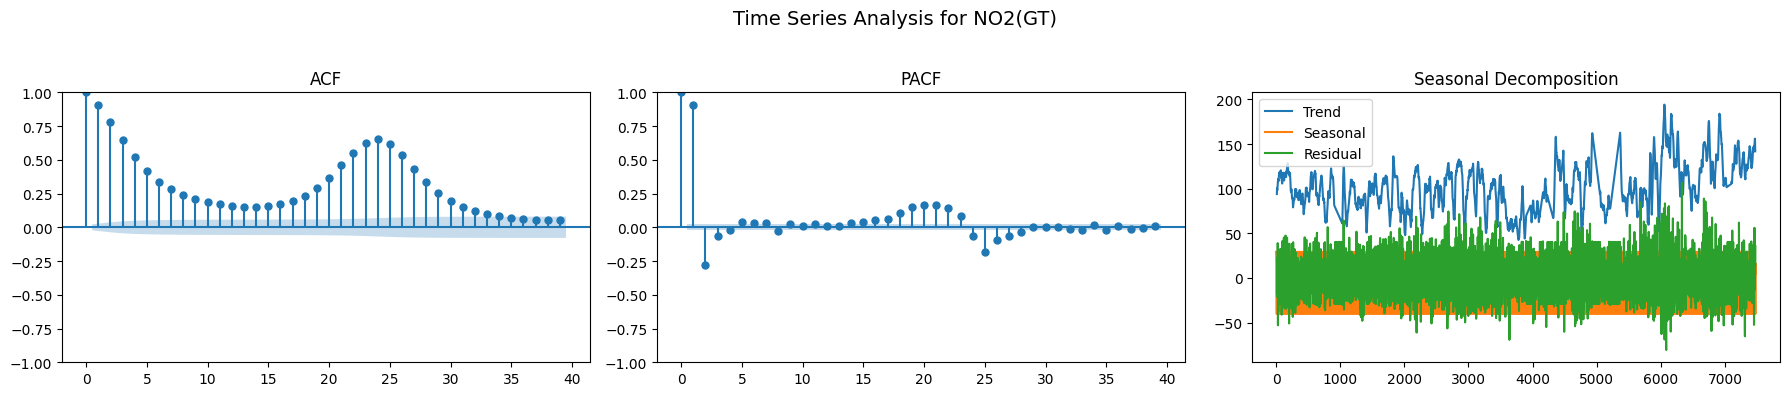

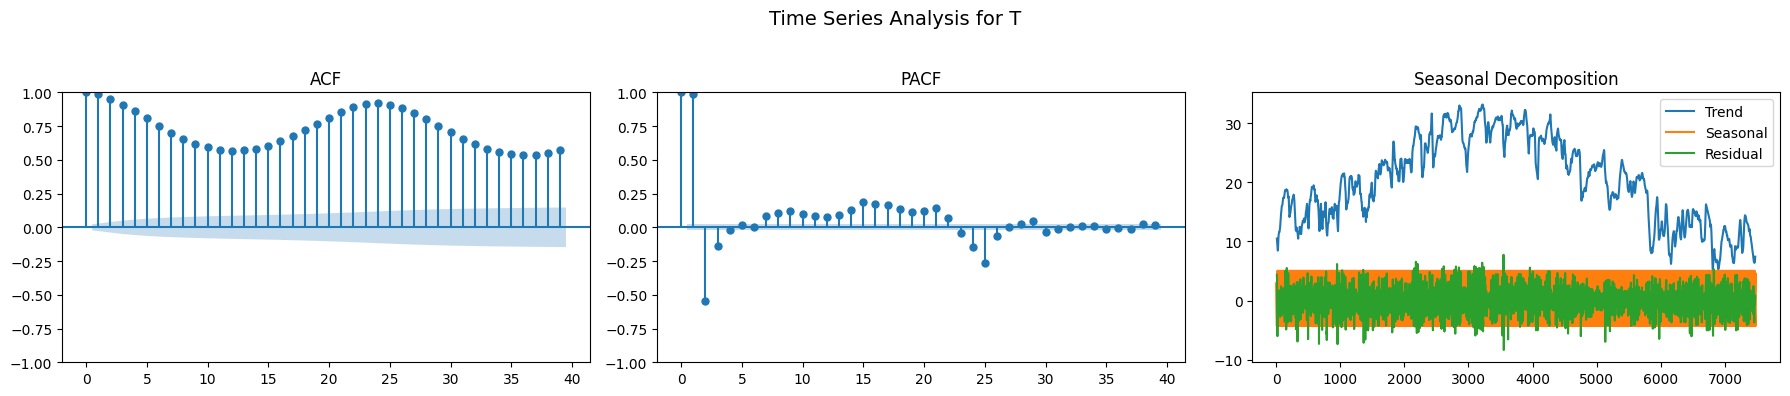

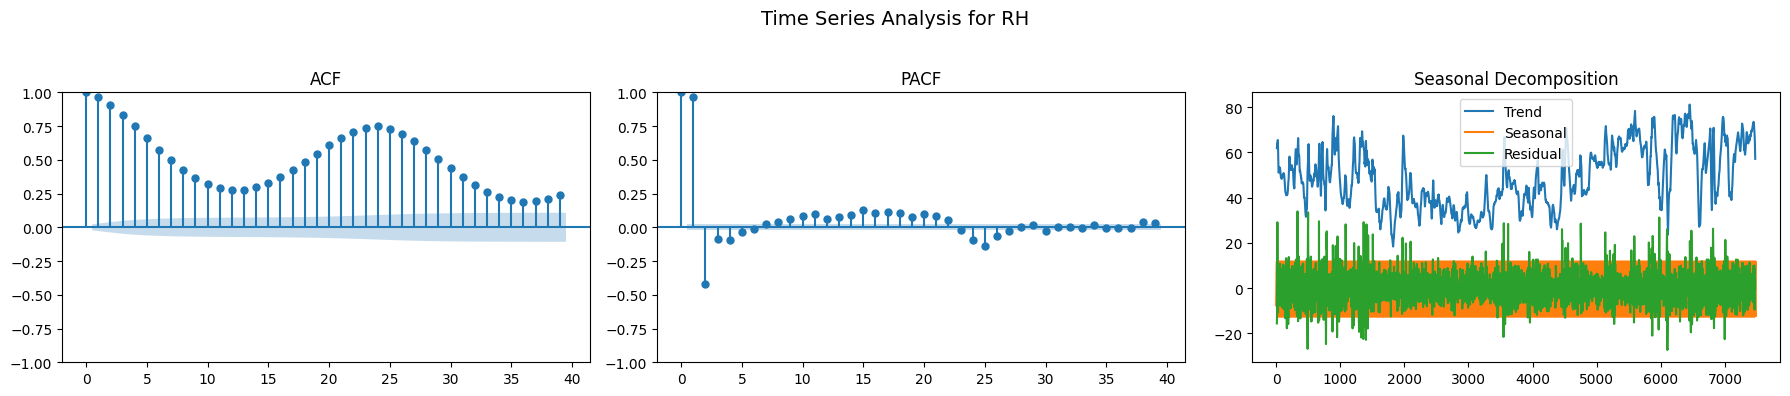

In [14]:
get_seasonal_decomposition(df, variables)

### 1.2. PM2.5 Beijing

In [15]:
database_name = "UCI"
dataset_name = "PRSA_BEIJING"

In [16]:
df = pd.read_csv(f"{DATASETS_FOLDER}/{database_name.lower()}/{dataset_name.lower()}.csv")
keep_cols = ["ds", "pm2_5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]

In [17]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
pm2_5: 95.28%
DEWP: 100.0%
TEMP: 100.0%
PRES: 100.0%
cbwd: 100.0%
Iws: 100.0%
Is: 100.0%
Ir: 100.0%


In [18]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 43824
Time period: 2010-1-1-0 - 2014-12-31-23
Number of rows with at least one missing value: 2067 (4.72)%


pm2_5      DEWP      TEMP      PRES       Iws        Is        Ir
count  41757.00  43824.00  43824.00  43824.00  43824.00  43824.00  43824.00
mean      98.61      1.82     12.45   1016.45     23.89      0.05      0.19
std       92.05     14.43     12.20     10.27     50.01      0.76      1.42
min        0.00    -40.00    -19.00    991.00      0.45      0.00      0.00
25%       29.00    -10.00      2.00   1008.00      1.79      0.00      0.00
50%       72.00      2.00     14.00   1016.00      5.37      0.00      0.00
75%      137.00     15.00     23.00   1025.00     21.91      0.00      0.00
max      994.00     28.00     42.00   1046.00    585.60     27.00     36.00

In [19]:
df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

In [20]:
for variable in variables:
    check_adf(df[variable], variable)


ADF Test for pm2_5:
  Test Statistic: -19.04517082261926574915
  p-value: 0.0 x 10^0
  ✅ Likely stationary

ADF Test for DEWP:
  Test Statistic: -5.45871296260710003878
  p-value: 2.5 x 10^-6
  ✅ Likely stationary

ADF Test for TEMP:
  Test Statistic: -3.63213558477096221111
  p-value: 5.2 x 10^-3
  ✅ Likely stationary

ADF Test for PRES:
  Test Statistic: -7.67974913398885394855
  p-value: 1.5 x 10^-11
  ✅ Likely stationary

ADF Test for Iws:
  Test Statistic: -30.48744138589807306516
  p-value: 0.0 x 10^0
  ✅ Likely stationary

ADF Test for Is:
  Test Statistic: -26.90397944541181729505
  p-value: 0.0 x 10^0
  ✅ Likely stationary

ADF Test for Ir:
  Test Statistic: -30.07326452203029987231
  p-value: 0.0 x 10^0
  ✅ Likely stationary


Estimated dominant period for pm2_5: 11680
Estimated dominant period for DEWP: 8760
Estimated dominant period for TEMP: 8760
Estimated dominant period for PRES: 8760
Estimated dominant period for Iws: 8760
Estimated dominant period for Is: 8760
Estimated dominant period for Ir: 8760


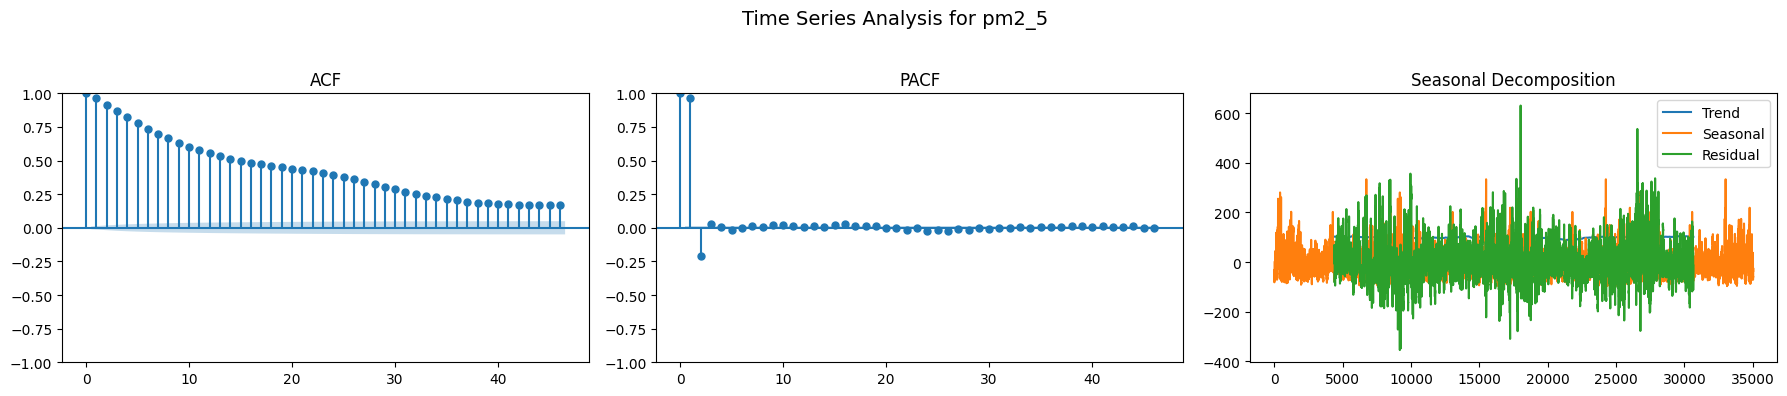

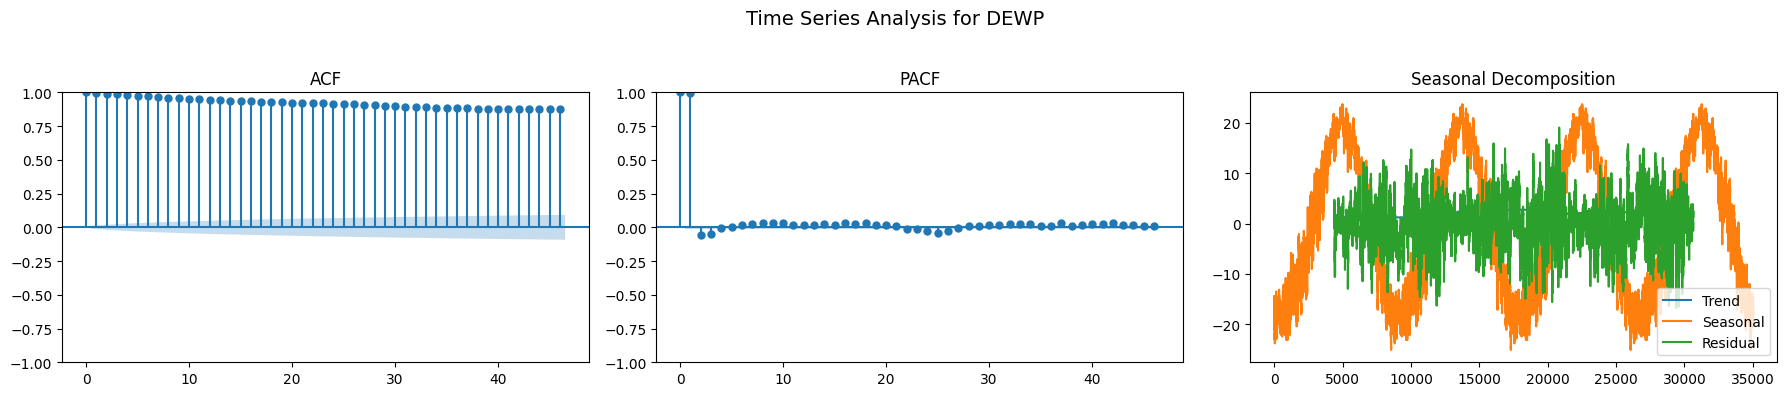

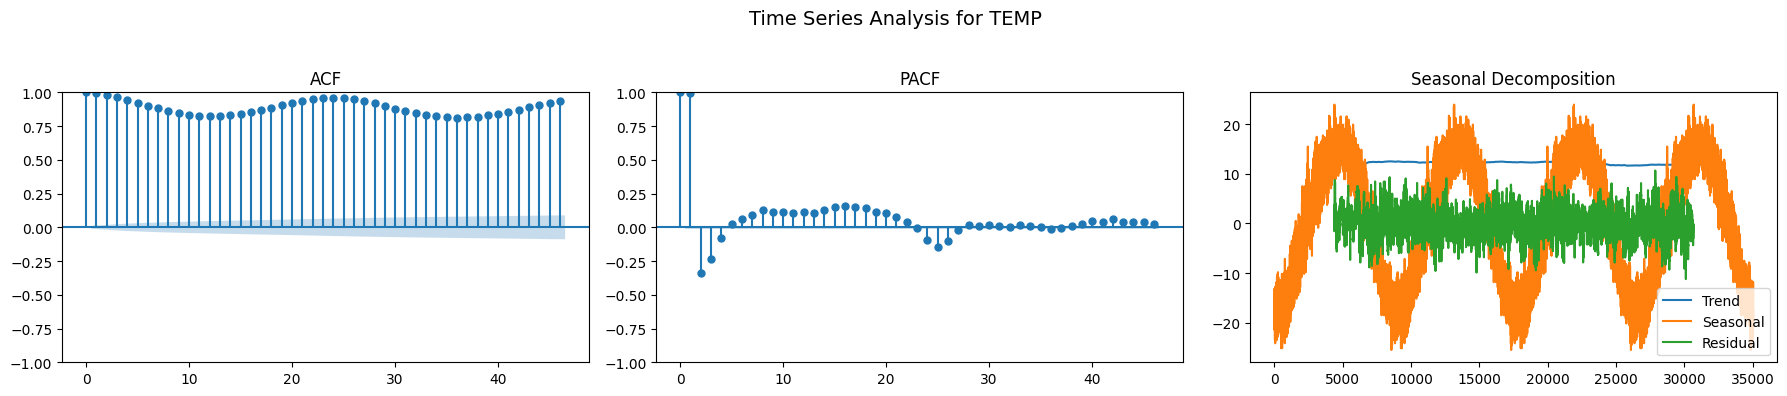

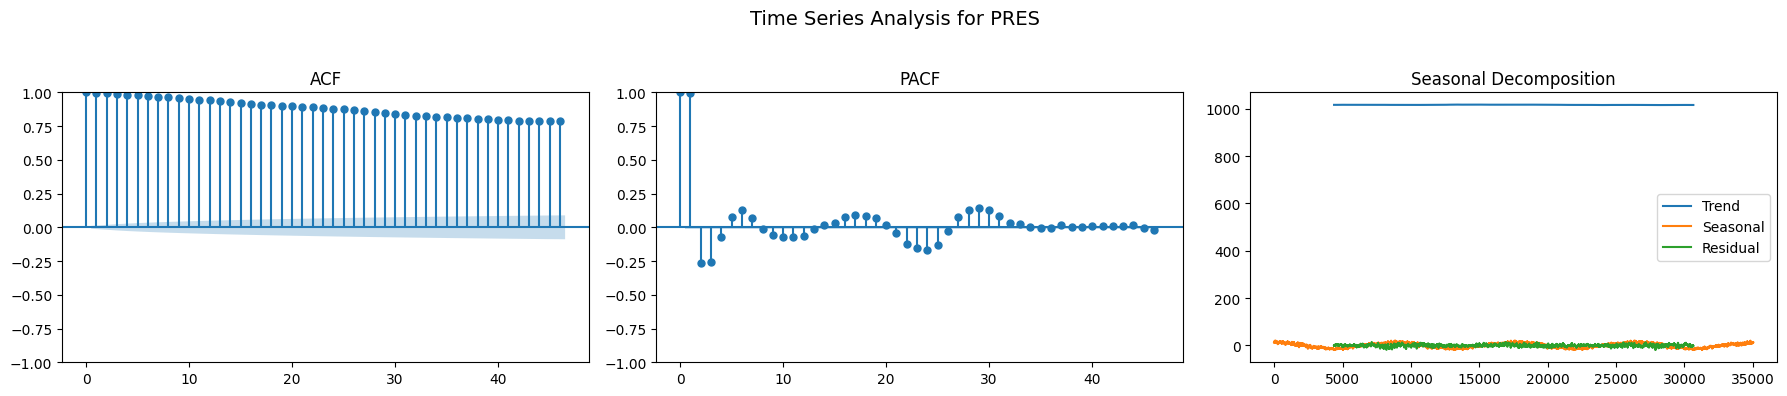

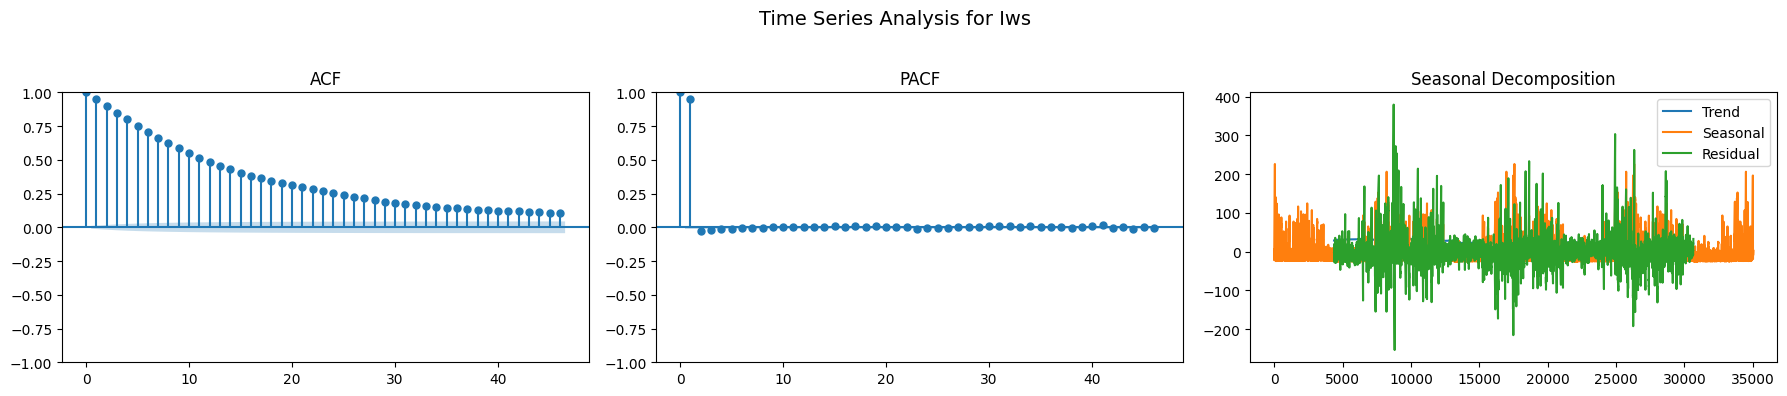

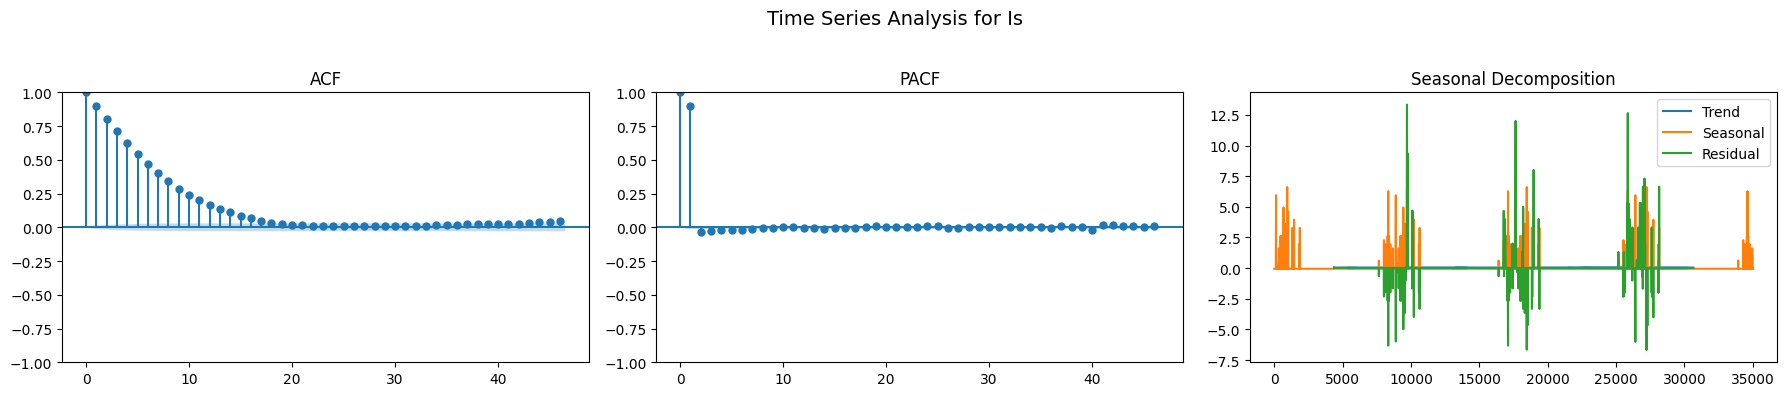

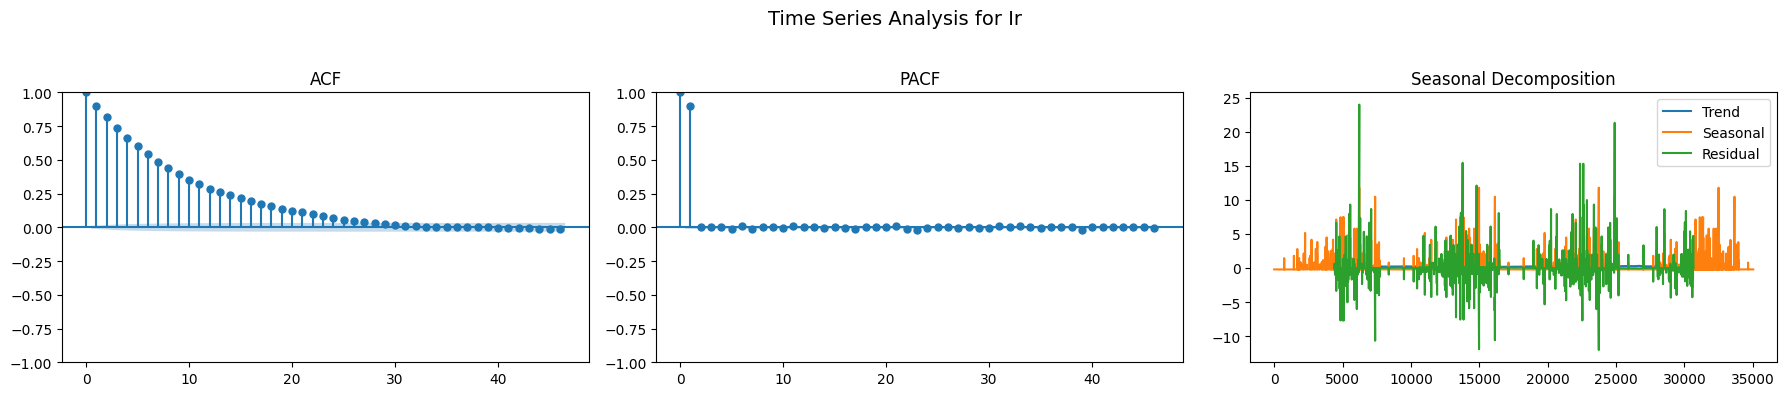

In [21]:
get_seasonal_decomposition(df, variables)

### 1.3. Appliances Energy

In [22]:
database_name = "UCI"
dataset_name = "APPLIANCES_ENERGY"

In [23]:
df = pd.read_csv(f"{DATASETS_FOLDER}/{database_name.lower()}/{dataset_name.lower()}.csv")
keep_cols = ["ds", "T_out", "Press_mm_hg", "RH_out", "Windspeed", "Visibility", "Tdewpoint"]

In [24]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
Appliances: 100.0%
lights: 100.0%
T1: 100.0%
RH_1: 100.0%
T2: 100.0%
RH_2: 100.0%
T3: 100.0%
RH_3: 100.0%
T4: 100.0%
RH_4: 100.0%
T5: 100.0%
RH_5: 100.0%
T6: 100.0%
RH_6: 100.0%
T7: 100.0%
RH_7: 100.0%
T8: 100.0%
RH_8: 100.0%
T9: 100.0%
RH_9: 100.0%
T_out: 100.0%
Press_mm_hg: 100.0%
RH_out: 100.0%
Windspeed: 100.0%
Visibility: 100.0%
Tdewpoint: 100.0%
rv1: 100.0%
rv2: 100.0%


In [25]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 19735
Time period: 11/01/16 17:00 - 27/05/16 18:00
Number of rows with at least one missing value: 0 (0.0)%


T_out  Press_mm_hg    RH_out  Windspeed  Visibility  Tdewpoint
count  19735.00     19735.00  19735.00   19735.00    19735.00   19735.00
mean       7.41       755.52     79.75       4.04       38.33       3.76
std        5.32         7.40     14.90       2.45       11.79       4.20
min       -5.00       729.30     24.00       0.00        1.00      -6.60
25%        3.67       750.93     70.33       2.00       29.00       0.90
50%        6.92       756.10     83.67       3.67       40.00       3.43
75%       10.40       760.93     91.67       5.50       40.00       6.57
max       26.10       772.30    100.00      14.00       66.00      15.50

In [26]:
df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

In [27]:
for variable in variables:
    check_adf(df[variable], variable)


ADF Test for T_out:
  Test Statistic: -7.91605175083173318029
  p-value: 3.8 x 10^-12
  ✅ Likely stationary

ADF Test for Press_mm_hg:
  Test Statistic: -5.04213044104795571343
  p-value: 1.8 x 10^-5
  ✅ Likely stationary

ADF Test for RH_out:
  Test Statistic: -14.59415544300499867347
  p-value: 4.3 x 10^-27
  ✅ Likely stationary

ADF Test for Windspeed:
  Test Statistic: -8.86670577775891111116
  p-value: 1.4 x 10^-14
  ✅ Likely stationary

ADF Test for Visibility:
  Test Statistic: -15.75062472743760189076
  p-value: 1.2 x 10^-28
  ✅ Likely stationary

ADF Test for Tdewpoint:
  Test Statistic: -5.19394995327387221096
  p-value: 9.0 x 10^-6
  ✅ Likely stationary


Estimated dominant period for T_out: 7894
Estimated dominant period for Press_mm_hg: 3947
Estimated dominant period for RH_out: 144
Estimated dominant period for Windspeed: 1754
Estimated dominant period for Visibility: 122
Estimated dominant period for Tdewpoint: 7894


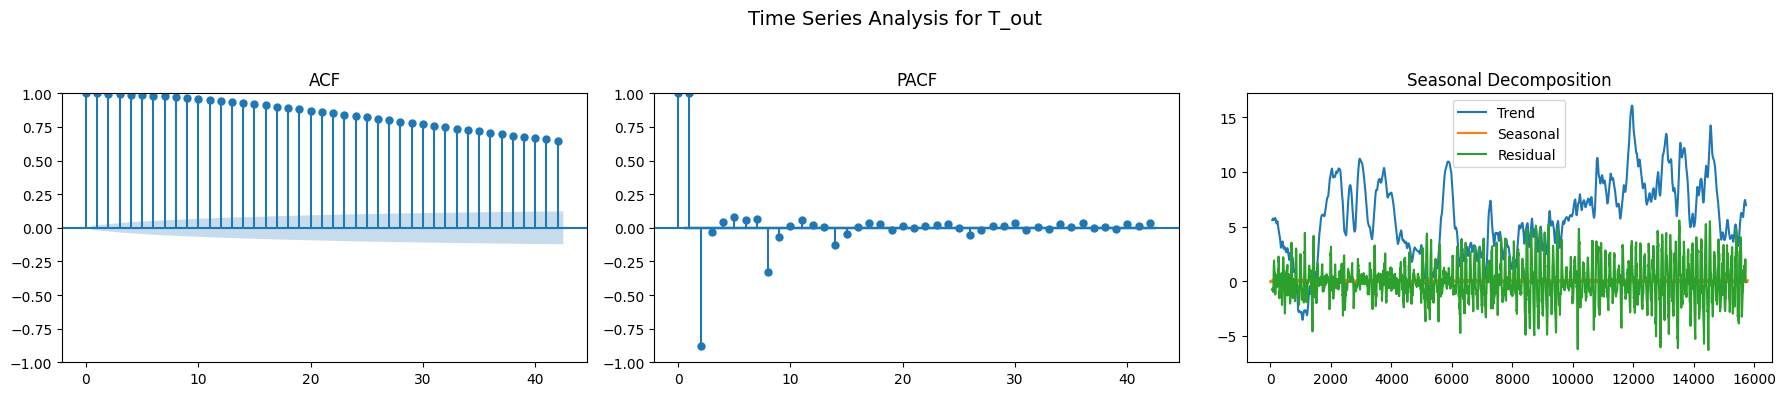

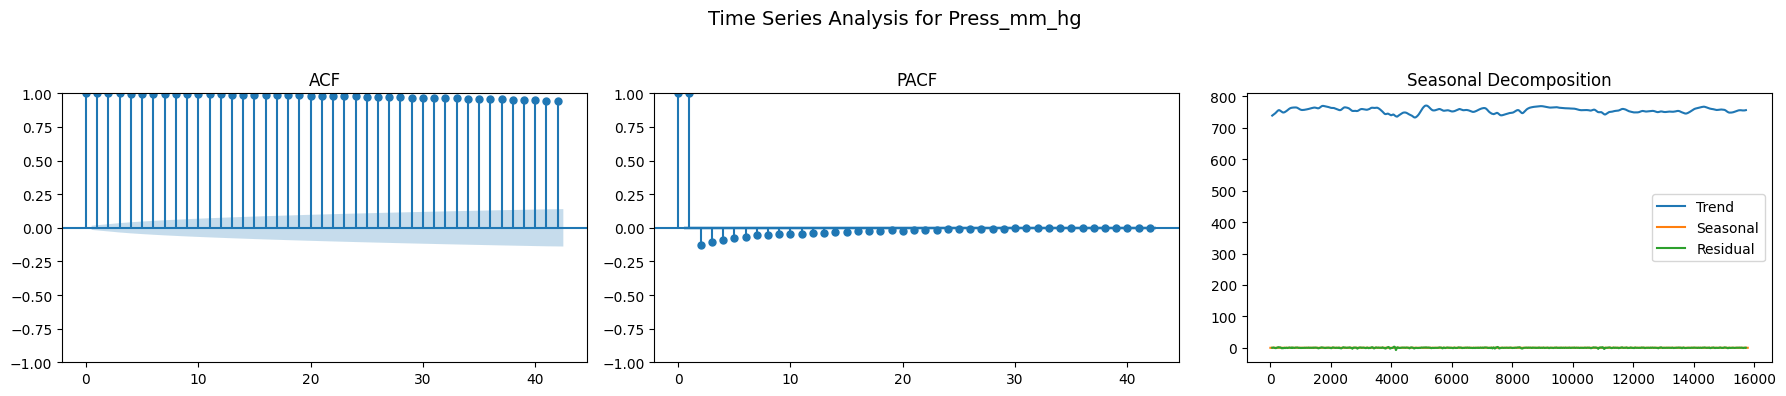

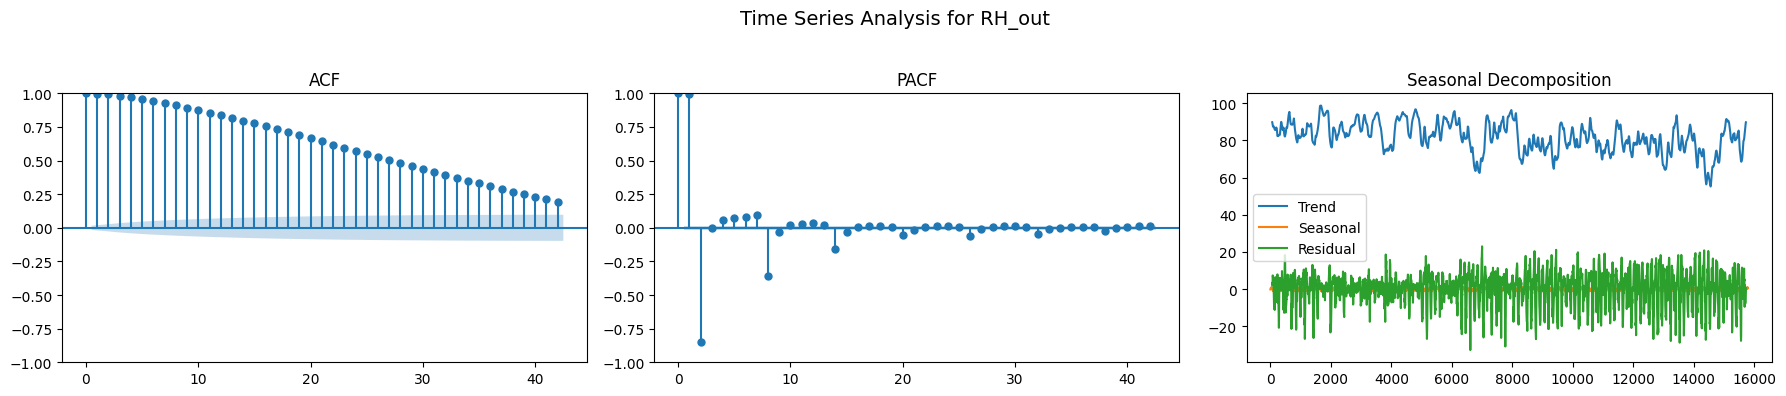

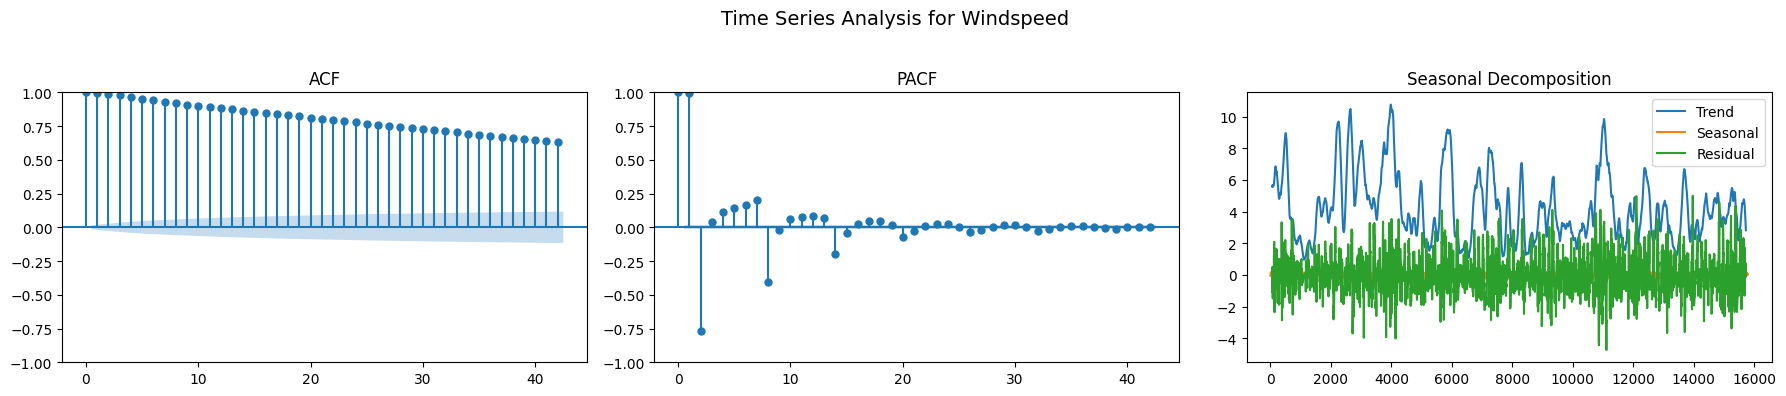

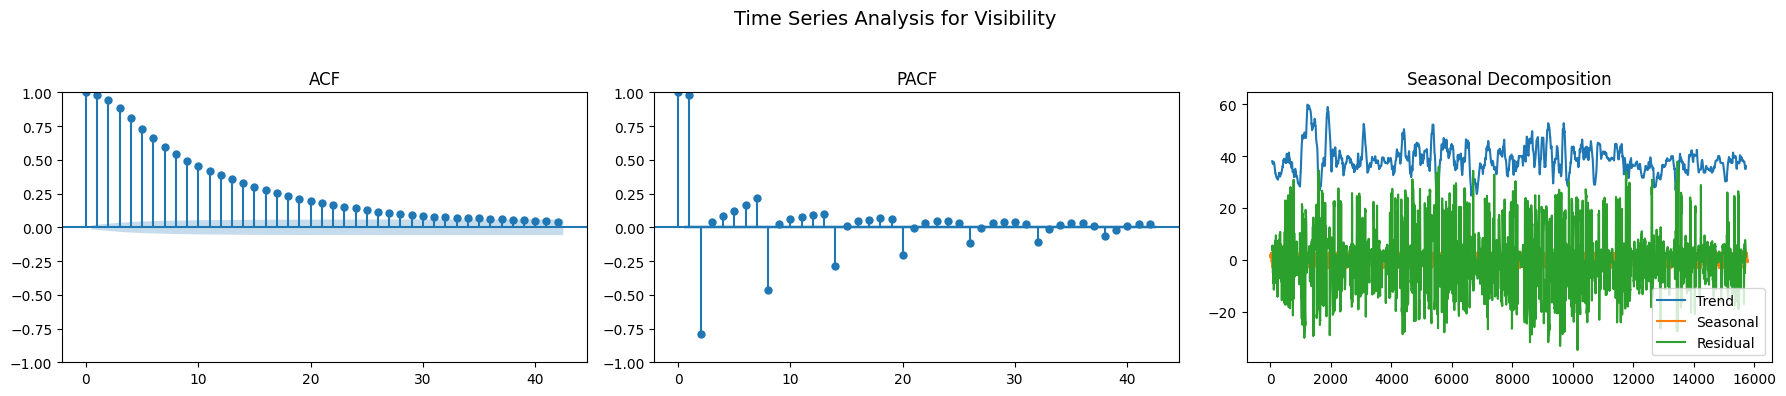

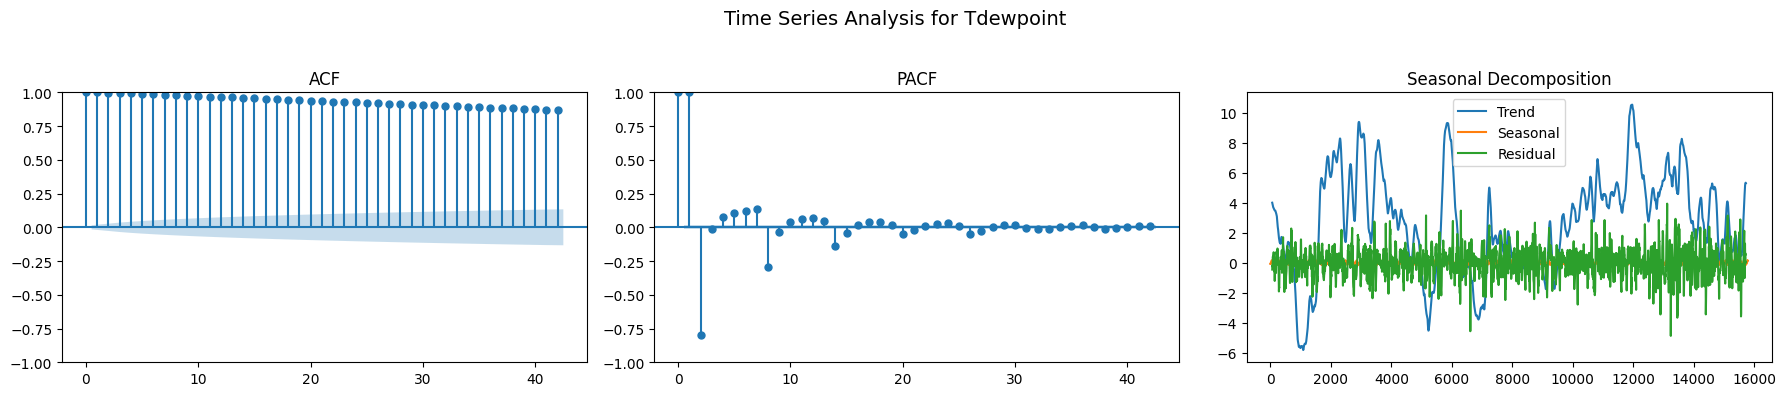

In [28]:
get_seasonal_decomposition(df, variables)

### 1.4. Metro Traffic

In [29]:
database_name = "UCI"
dataset_name = "METRO_TRAFFIC"

In [30]:
df = pd.read_csv(f"{DATASETS_FOLDER}/{database_name.lower()}/{dataset_name.lower()}.csv")
keep_cols = ["ds", "temp", "rain_1h", "clouds_all"]

In [31]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
holiday: 0.12999999999999545%
temp: 100.0%
rain_1h: 100.0%
snow_1h: 100.0%
clouds_all: 100.0%
weather_main: 100.0%
weather_description: 100.0%
traffic_volume: 100.0%


In [32]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 48204
Time period: 02/10/12 09:00 - 30/09/18 23:00
Number of rows with at least one missing value: 0 (0.0)%


temp   rain_1h  clouds_all
count  48204.00  48204.00    48204.00
mean     281.21      0.33       49.36
std       13.34     44.79       39.02
min        0.00      0.00        0.00
25%      272.16      0.00        1.00
50%      282.45      0.00       64.00
75%      291.81      0.00       90.00
max      310.07   9831.30      100.00

In [33]:
df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

In [34]:
for variable in variables:
    check_adf(df[variable], variable)


ADF Test for temp:
  Test Statistic: -5.65721262741679353780
  p-value: 9.6 x 10^-7
  ✅ Likely stationary

ADF Test for rain_1h:
  Test Statistic: -196.31430094894832905084
  p-value: 0.0 x 10^0
  ✅ Likely stationary

ADF Test for clouds_all:
  Test Statistic: -25.73280830378579153717
  p-value: 0.0 x 10^0
  ✅ Likely stationary


Estimated dominant period for temp: 9641
Estimated dominant period for rain_1h: 9641
Estimated dominant period for clouds_all: 9641


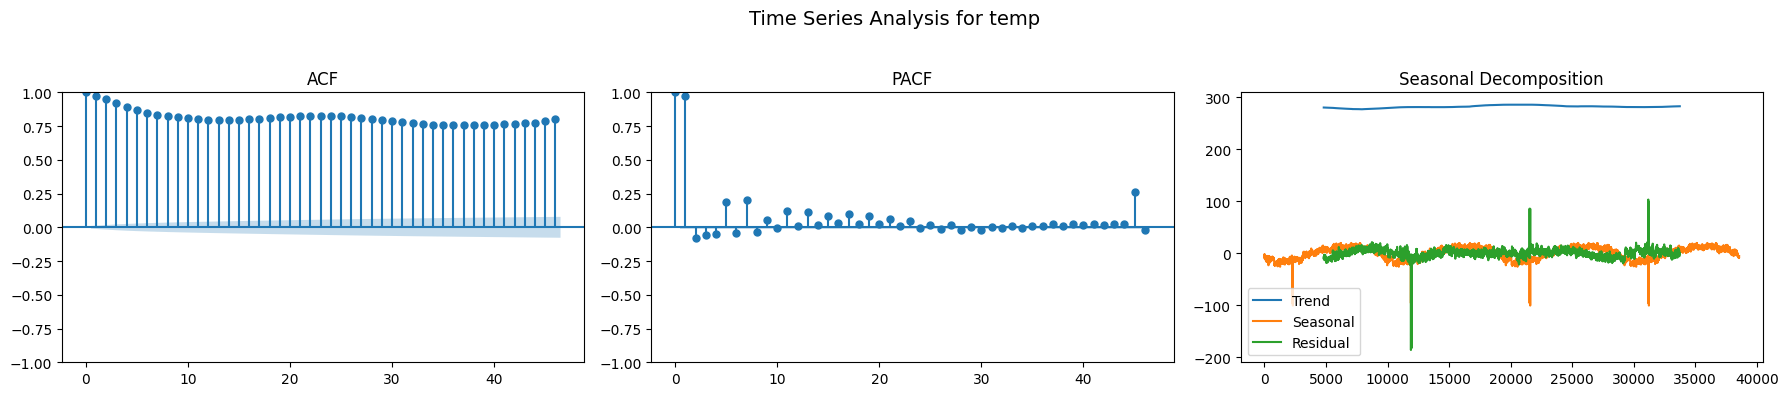

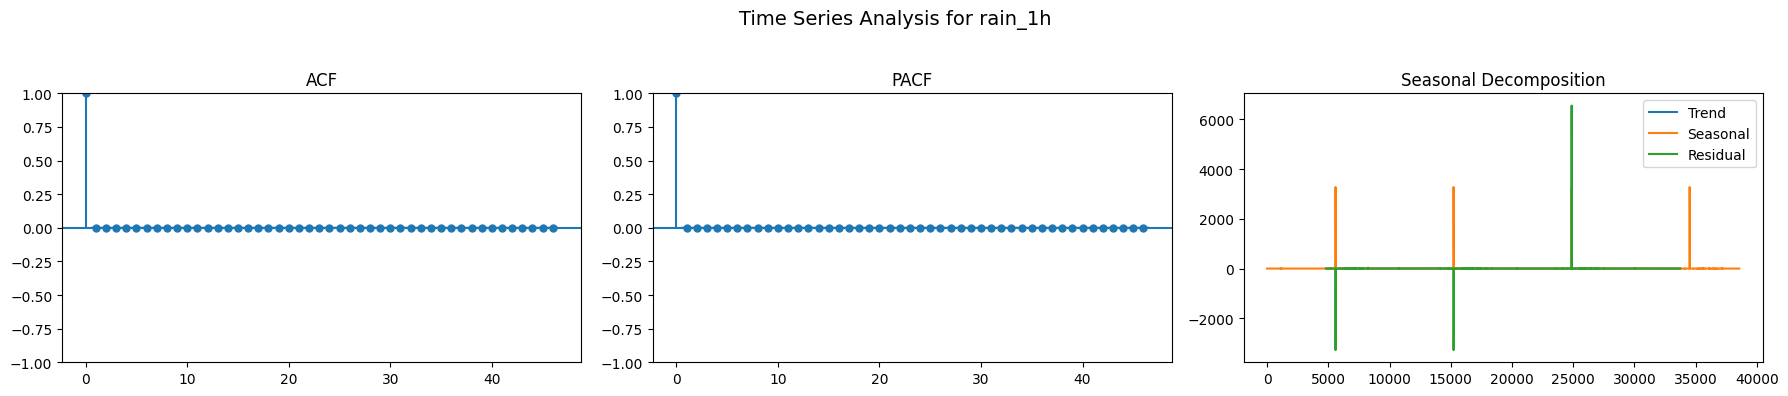

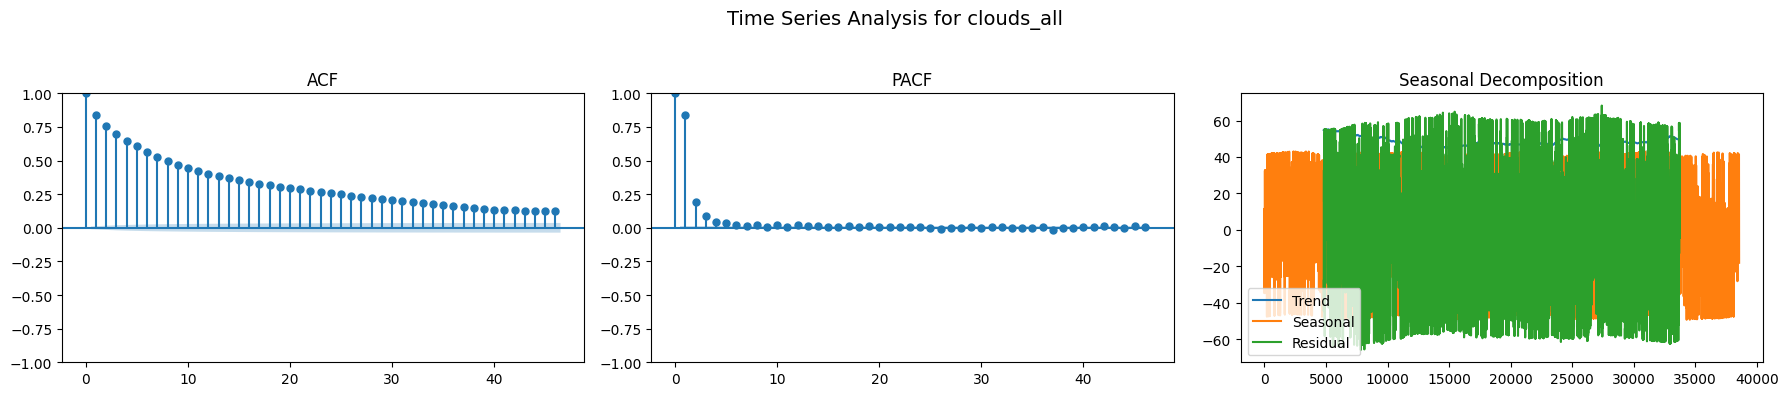

In [35]:
get_seasonal_decomposition(df, variables)

## 2. Individual Results Analysis

In [36]:
DATASETS_NAMES = [
    "UCI_AIR_QUALITY",
    "UCI_PRSA_BEIJING",
    "UCI_APPLIANCES_ENERGY",
    "UCI_METRO_TRAFFIC",
]

RMSE_COL = "Avg_RMSE"
ET_COL = "total_perf_duration"
ET_MIN_COL = "total_perf_duration_minutes"
CHANGE_POINT_PERC_COL = "change_point_perc"
CHANGE_POINT_APPROACH_COL = "change_point_approach"
DATASET_NAME_COL = "dataset_name"

In [37]:
SEEDS = [0, 42, 52, 101, 214, 565, 600, 713, 999, 1001]
EXPECTED_NUMBER_APPROACHES = (3 * 7) + 10

In [38]:
def get_df_for_dataset(seed: int, database_name: str, dataset_name: str) -> pd.DataFrame:
    def get_df_for_dataset_inner() -> pd.DataFrame:
        directory_path = f"outputs/report/seed={seed}/{database_name}/{dataset_name}"

        print(f"Reading from {directory_path}")

        metrics_dfs = []
        
        for root, dirs, files in os.walk(directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(root, filename)
                    
                    try:
                        with open(file_path, 'r') as file:
                            data = json.load(file)
                            metrics_dfs.append(
                                pd.DataFrame({
                                    'change_point_method': [data.get('change_point_method', np.nan)],
                                    'change_point_cost_function': [data.get('change_point_cost_function', np.nan)],
                                    'change_point_approach': [data.get('change_point_approach', np.nan)],
                                    'change_point_perc': [data.get('change_point_perc', np.nan)],
                                    'detect_change_point_duration': [data.get('detect_change_point_perf_duration', np.nan)],
                                    'detect_change_point_duration_minutes': [data.get('detect_change_point_perf_duration', np.nan) / 60],
                                    'tuner_duration': [data.get('tuner_perf_duration', np.nan)],
                                    'tuner_duration_minutes': [data.get('tuner_perf_duration', np.nan) / 60],
                                    'retrain_duration': [data.get('retrain_perf_duration', np.nan)],
                                    'retrain_duration_minutes': [data.get('retrain_perf_duration', np.nan) / 60],
                                    'forecasting_test_duration': [data.get('forecasting_test_perf_duration', np.nan)],
                                    'forecasting_test_duration_minutes': [data.get('forecasting_test_perf_duration', np.nan) / 60],
                                    'total_duration': [data.get('total_time_duration', np.nan)],
                                    'total_duration_minutes': [data.get('total_time_duration', np.nan) / 60],
                                    'total_perf_duration': [data.get('total_perf_duration', np.nan)],
                                    'total_perf_duration_minutes': [data.get('total_perf_duration', np.nan) / 60],
                                    'total_process_duration': [data.get('total_process_duration', np.nan)],
                                    'total_process_duration_minutes': [data.get('total_process_duration', np.nan) / 60],
                                    'Avg_MAPE': [data.get('error_results', {}).get('Avg_MAPE', np.nan)],
                                    'Avg_MAE': [data.get('error_results', {}).get('Avg_MAE', np.nan)],
                                    'Avg_MSE': [data.get('error_results', {}).get('Avg_MSE', np.nan)],
                                    'Avg_RMSE': [data.get('error_results', {}).get('Avg_RMSE', np.nan)],
                                    'Avg_R2':  [data.get('error_results', {}).get('Avg_R2', np.nan)],
                                }))
                    except KeyError as e:
                        print(f"Error in {file_path}: {e}")
                        continue
                    
        metrics_df = pd.concat(metrics_dfs, axis=0)
    
        replacements = {
            'Rbf': 'RBF',
            ' Ar': ' AR',
            'Bin_Seg': 'BinSeg',
            'Bottom_Up': 'BottomUp',
            'Fixed_Perc Fixed_Cut_0.0': 'No CPD',
            'Fixed_Perc Fixed_Cut_': 'Fixed Cut ',
            '0.1': '10%',
            '0.2': '20%',
            '0.3': '30%',
            '0.4': '40%',
            '0.5': '50%',
            '0.6': '60%',
            '0.7': '70%',
            '0.8': '80%',
            '0.9': '90%',
        }
        for old, new in replacements.items():
            metrics_df['change_point_approach'] = metrics_df['change_point_approach'].str.replace(old, new)

        return metrics_df

    metrics_df = get_df_for_dataset_inner()
    metrics_cols = metrics_df.columns.tolist()
    metrics_df['database'] = [database_name] * len(metrics_df)
    metrics_df['dataset'] = [dataset_name] * len(metrics_df)
    metrics_df = metrics_df[['database', 'dataset'] + metrics_cols]

    return metrics_df.reset_index(drop=True)


def highlight_rows(row):
    approach = row['change_point_approach']
    if isinstance(approach, str):
        if 'Fixed' in approach:
            return ['background-color: darkslateblue'] * len(row)
        elif approach == 'Full':
            return ['background-color: darkgoldenrod'] * len(row)
        elif 'Window' in approach:
            return ['background-color: darkmagenta'] * len(row)
        elif 'BottomUp' in approach:
            return ['background-color: darkolivegreen'] * len(row)
        elif 'BinSeg' in approach:
            return ['background-color: teal'] * len(row)
    return [''] * len(row)

In [39]:
def get_individual_results(datasets_dict, dataset_name):
    relevant_metrics = [CHANGE_POINT_PERC_COL, RMSE_COL, ET_COL, ET_MIN_COL]
    concat_df = None        
    for seed in datasets_dict[dataset_name].keys():
        df = datasets_dict[dataset_name][seed].copy()
        df[DATASET_NAME_COL] = dataset_name
        df = df[[DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL] + relevant_metrics]
        df = df.rename(columns={
            CHANGE_POINT_PERC_COL: f"{CHANGE_POINT_PERC_COL}_seed_{seed}",
            RMSE_COL: f"{RMSE_COL}_seed_{seed}",
            ET_COL: f"{ET_COL}_seed_{seed}",
            ET_MIN_COL: f"{ET_MIN_COL}_seed_{seed}",
        })
        if concat_df is None:
            concat_df = df
        else:
            concat_df = pd.merge(concat_df, df, on=[DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL], how='left')

    for metric in relevant_metrics:
        metric_cols = [col for col in concat_df.columns if f"{metric}_seed_" in col]
        if metric_cols:
            concat_df[f"{metric}_mean"] = concat_df[metric_cols].mean(axis=1, skipna=True)
            concat_df[f"{metric}_std"] = concat_df[metric_cols].std(axis=1, skipna=True)

    concat_df = concat_df.round(2).sort_values(by=CHANGE_POINT_APPROACH_COL)
    concat_df.to_excel(f"{OUTPUT_FOLDER}/{dataset_name}_Results.xlsx")
    return concat_df

In [40]:
datasets_dict = {}
for dataset_name in DATASETS_NAMES:
    datasets_dict[dataset_name] = {}

In [41]:
individual_metrics_dict = {}
for dataset_name in DATASETS_NAMES:
    individual_metrics_dict[dataset_name] = None

### 2.1. [UCI] Air Quality

In [42]:
database_name = "UCI"
dataset_name = "AIR_QUALITY"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/AIR_QUALITY
Reading from outputs/report/seed=42/UCI/AIR_QUALITY
Reading from outputs/report/seed=52/UCI/AIR_QUALITY
Reading from outputs/report/seed=101/UCI/AIR_QUALITY
Reading from outputs/report/seed=214/UCI/AIR_QUALITY
Reading from outputs/report/seed=565/UCI/AIR_QUALITY
Reading from outputs/report/seed=600/UCI/AIR_QUALITY
Reading from outputs/report/seed=713/UCI/AIR_QUALITY
Reading from outputs/report/seed=999/UCI/AIR_QUALITY
Reading from outputs/report/seed=1001/UCI/AIR_QUALITY


### 2.2. [UCI] PM2.5 BEIJING

In [43]:
database_name = "UCI"
dataset_name = "PRSA_BEIJING"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/PRSA_BEIJING
Reading from outputs/report/seed=42/UCI/PRSA_BEIJING
Reading from outputs/report/seed=52/UCI/PRSA_BEIJING
Reading from outputs/report/seed=101/UCI/PRSA_BEIJING
Reading from outputs/report/seed=214/UCI/PRSA_BEIJING
Reading from outputs/report/seed=565/UCI/PRSA_BEIJING
Reading from outputs/report/seed=600/UCI/PRSA_BEIJING
Reading from outputs/report/seed=713/UCI/PRSA_BEIJING
Reading from outputs/report/seed=999/UCI/PRSA_BEIJING
Reading from outputs/report/seed=1001/UCI/PRSA_BEIJING


### 2.3. [UCI] Appliances Energy

In [44]:
database_name = "UCI"
dataset_name = "APPLIANCES_ENERGY"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=42/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=52/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=101/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=214/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=565/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=600/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=713/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=999/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=1001/UCI/APPLIANCES_ENERGY


### 2.4. [UCI] Metro Traffic

In [45]:
database_name = "UCI"
dataset_name = "METRO_TRAFFIC"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=42/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=52/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=101/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=214/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=565/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=600/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=713/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=999/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=1001/UCI/METRO_TRAFFIC


### 2.5. Get Latex Tables

In [46]:
def get_latex_tables(col_prefix: str, file_name: str, table_caption: str, table_label: str) -> str:
    approaches = individual_metrics_dict["UCI_AIR_QUALITY"]["change_point_approach"].tolist()

    mean_col = f"{col_prefix}_mean"
    std_col = f"{col_prefix}_std"

    best_values = {
        dataset: individual_metrics_dict[dataset][mean_col].min()
        for dataset in individual_metrics_dict
    }

    latex_rows = []
    for i, approach in enumerate(approaches):
        values = []
        for dataset, df in individual_metrics_dict.items():
            row = df.iloc[i]
            value_str = f"{row[mean_col]:.2f} $\\pm$ {row[std_col]:.2f}"
            if row[mean_col] == best_values[dataset]:
                value_str = f"\\textbf{{{value_str}}}"
            values.append(value_str)
        latex_rows.append(f"{approach} & " + " & ".join(values) + r" \\")

    latex_table = (
        "\\begin{table}[!htpb] \\small\n"
        f"    \\caption{{{table_caption}}}\n"
        "    \\centering\n"
        "    \\begin{tabular}{lcccc}\n"
        "        \\toprule\n"
        "        & \\makecell{\\textbf{Air}\\\\\\textbf{Quality}} \n"
        "        & \\makecell{\\textbf{Beijing}\\\\\\textbf{PM2.5}} \n"
        "        & \\makecell{\\textbf{Appliances}\\\\\\textbf{Energy}} \n"
        "        & \\makecell{\\textbf{Metro}\\\\\\textbf{Traffic}} \\\\\n"
        "        \\midrule\n"
        + "\n".join(latex_rows) +
        "\n        \\bottomrule\n"
        "    \\end{tabular}\n"
        f"    \\label{{{table_label}}}\n"
        "\\end{table}\n"
    )

    file_path = f"{OUTPUT_FOLDER}/{file_name}.tex"
    with open(file_path, "w") as f:
        f.write(latex_table)

In [47]:
get_latex_tables(
    col_prefix=RMSE_COL,
    file_name="rmse_results_table",
    table_caption="RMSE results for each dataset.",
    table_label="tab:rmse_results"
)

get_latex_tables(
    col_prefix=ET_MIN_COL,
    file_name="et_results_table",
    table_caption="Execution Time results (in minutes) for each dataset.",
    table_label="tab:etResults"
)

## 3. Plot Change Points

In [48]:
def plot_change_points(df, variables, cpds, filename=None):
    fig, axes = plt.subplots(len(variables), 1, figsize=(12, 3 * len(variables)), sharex=True)

    for i, (variable, ax) in enumerate(zip(variables, axes)):
        ax.plot(df.index, df[variable], linewidth=1)
        for j, cp in enumerate(cpds):
            cp = int(len(df) * cp / 100)
            ax.axvline(
                x=df.index[cp],
                color='red',
                linestyle='--',
                linewidth=1,
                label='Detected Change Point' if j == 0 else None
            )
        ax.set_ylabel(variable, rotation=0, ha='right', va='center')
        ax.set_title(variable.title(), fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()

    if filename:
        plt.savefig(f"{OUTPUT_FOLDER}/{filename}", dpi=300, bbox_inches='tight')

    plt.show()

### 3.1. [UCI] Air Quality

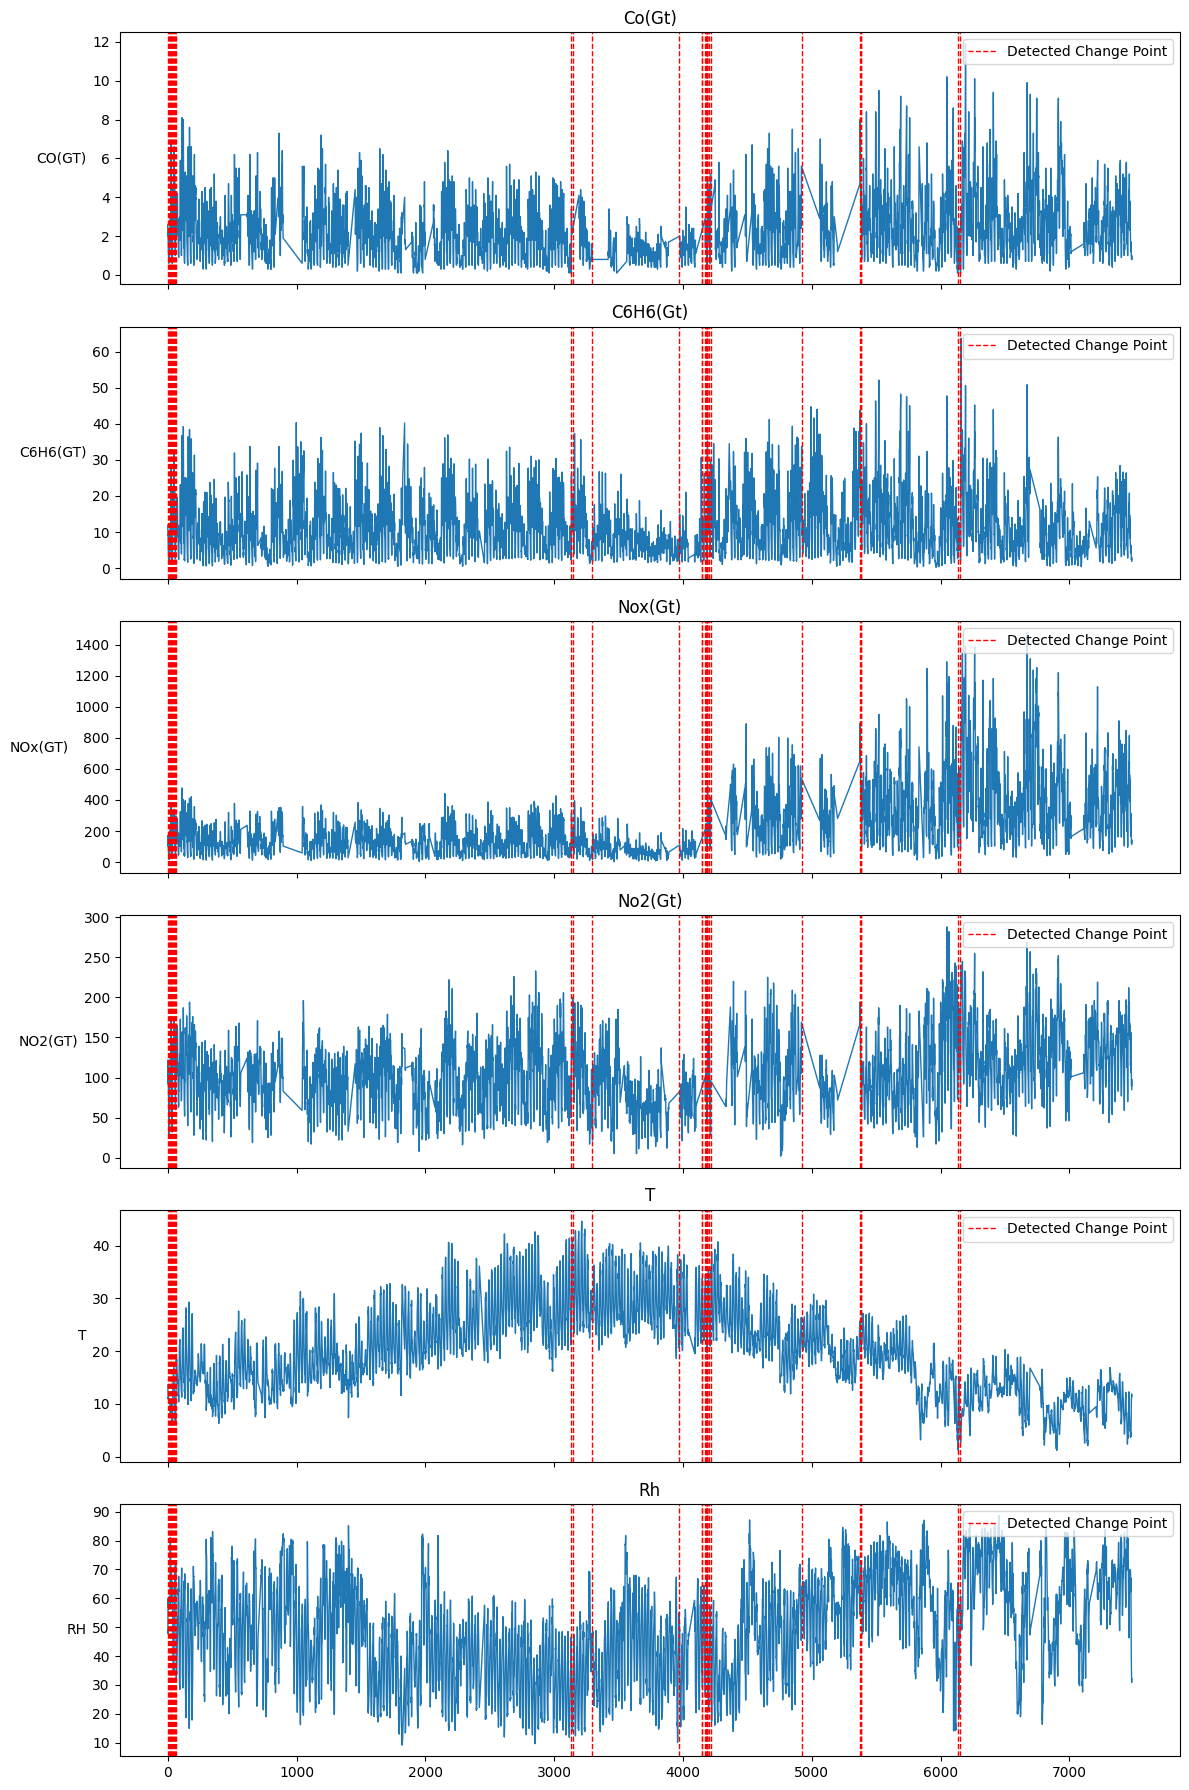

In [49]:
database_name = "UCI"
dataset_name = "AIR_QUALITY"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.2. [UCI] PM2.5 BEIJING

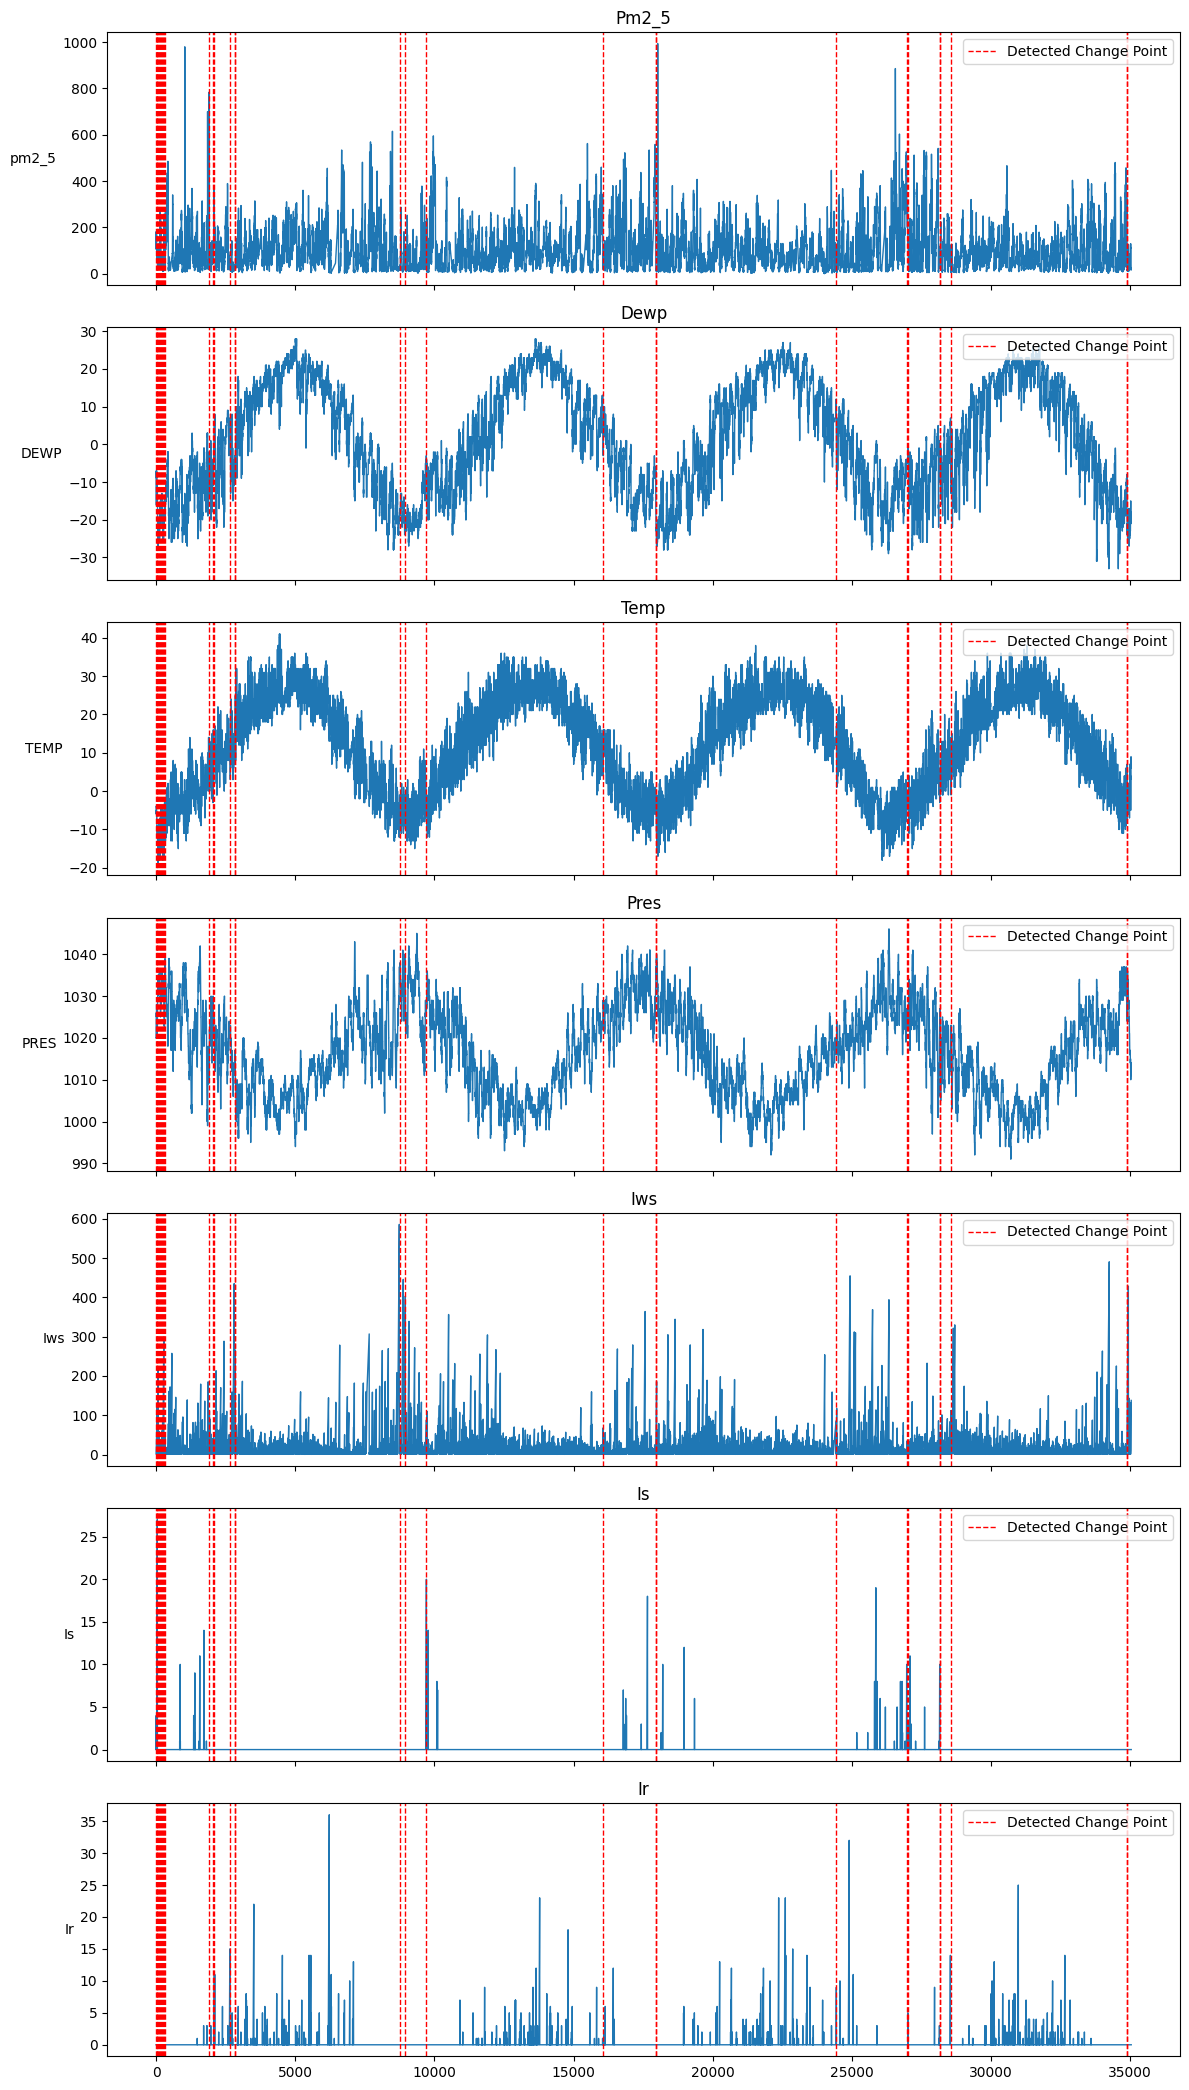

In [50]:
database_name = "UCI"
dataset_name = "PRSA_BEIJING"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.3. [UCI] Appliances Energy

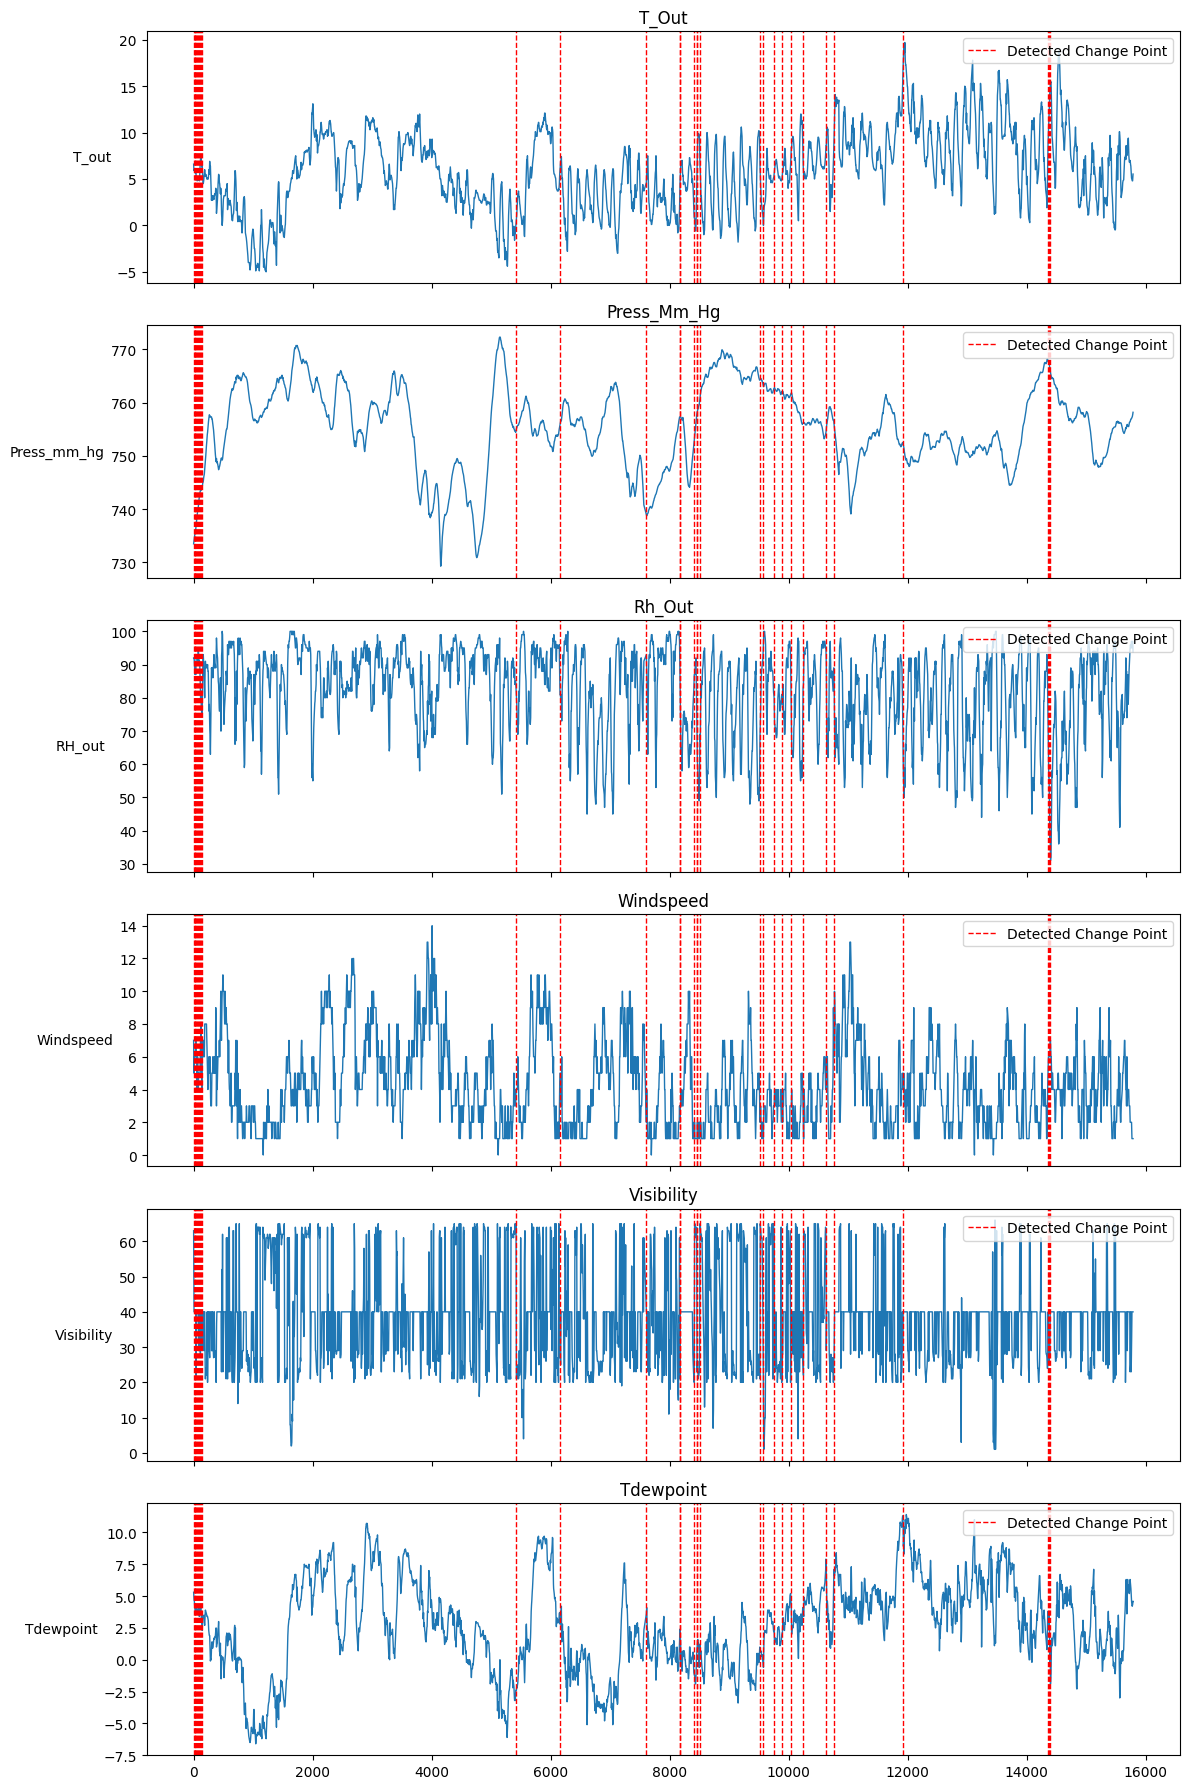

In [51]:
database_name = "UCI"
dataset_name = "APPLIANCES_ENERGY"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.4. [UCI] Metro Traffic

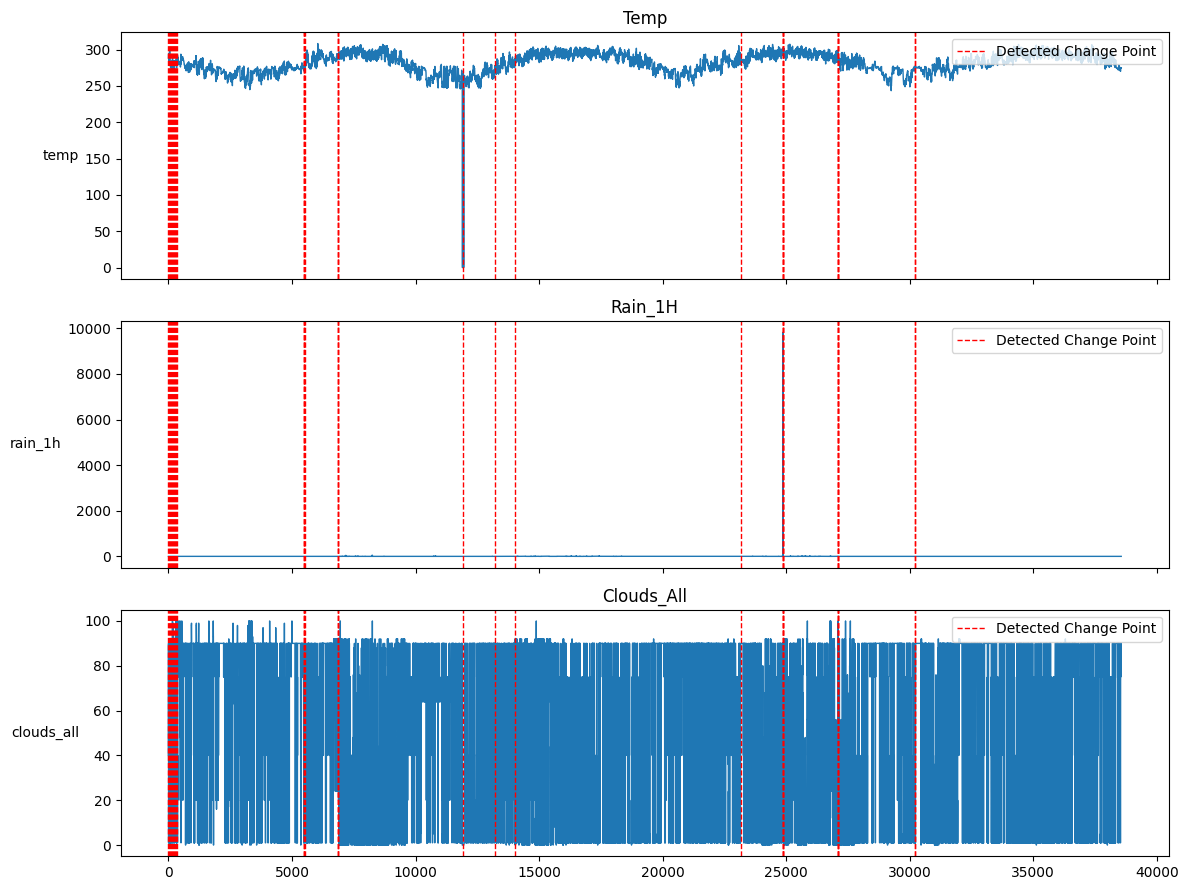

In [52]:
database_name = "UCI"
dataset_name = "METRO_TRAFFIC"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

## 4. ARR Rank

In [53]:
FIXED_APPROACHES = [
    'Fixed Cut 10%',
    'Fixed Cut 20%',
    'Fixed Cut 30%',
    'Fixed Cut 40%',
    'Fixed Cut 50%',
    'Fixed Cut 60%',
    'Fixed Cut 70%',
    'Fixed Cut 80%',
    'Fixed Cut 90%',
]

In [54]:
def compute_arr(df, acc_d, algorithm_p, algorithm_q, dataset, metric):
    df_d = df[df[DATASET_NAME_COL] == dataset]

    d_ap = df_d[df_d[CHANGE_POINT_APPROACH_COL] == algorithm_p]
    d_aq = df_d[df_d[CHANGE_POINT_APPROACH_COL] == algorithm_q]

    assert len(d_ap) == 1, f"Expected 1 line for approach {algorithm_p} but got {len(d_ap)}"
    assert len(d_aq) == 1, f"Expected 1 line for approach {algorithm_q} but got {len(d_aq)}"

    sr_ap = 1 / d_ap[metric].iloc[0]
    sr_aq = 1 / d_aq[metric].iloc[0]

    t_ap = d_ap[f"{ET_MIN_COL}_mean"].iloc[0]
    t_aq = d_aq[f"{ET_MIN_COL}_mean"].iloc[0]

    sr_ratio = sr_ap / sr_aq if sr_aq != 0 else np.nan  # Avoid division by zero
    time_ratio = np.log(t_ap / t_aq) if t_aq != 0 else np.nan  # Avoid division by zero

    arr = sr_ratio / (1 + acc_d * time_ratio)
    
    return arr


def compute_arr_ranking(df, acc_d, metric):
    algorithms = df[CHANGE_POINT_APPROACH_COL].unique()
    datasets = df[DATASET_NAME_COL].unique()
    arr_df = pd.DataFrame({
        DATASET_NAME_COL: [],
        'ap': [],
        'aq': [],
        'arr': [],
    })

    for dataset in datasets:
        for ap in algorithms:
            for aq in algorithms:
                if ap == aq:
                    continue

                arr_df = pd.concat([arr_df, pd.DataFrame({
                    DATASET_NAME_COL: [dataset],
                    'ap': [ap],
                    'aq': [aq],
                    'arr': [compute_arr(df, acc_d, ap, aq, dataset, metric)],
                })])

    grouped = arr_df.groupby(['ap', 'aq'])['arr'].apply(lambda x: np.prod(x) ** (1 / len(x))).reset_index()

    ranking_df = grouped.groupby('ap')['arr'].mean().reset_index()
    ranking_df['rank'] = ranking_df['arr'].rank(ascending=False, method='max')

    return ranking_df.sort_values(by='rank')

In [55]:
arr_rank_input_df = []
for dataset_name in DATASETS_NAMES:
    df = individual_metrics_dict[dataset_name][[
        DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL,
        f"{RMSE_COL}_mean", f"{ET_MIN_COL}_mean"
    ]]
    df = df[~df[CHANGE_POINT_APPROACH_COL].isin(FIXED_APPROACHES)]
    arr_rank_input_df.append(df)
arr_rank_input_df = pd.concat(arr_rank_input_df, axis=0)

In [56]:
ACC_D_LIST = np.arange(0.1, 1.05, 0.1).tolist()
ACC_D_LIST = [round(acc_d, 2) for acc_d in ACC_D_LIST]
arr_rank_dict = dict()

In [57]:
arr_rank_df = []

for acc_d in ACC_D_LIST:
    key = f"{RMSE_COL}_mean_{acc_d}"
    arr_rank_dict[key] = compute_arr_ranking(
        arr_rank_input_df, acc_d=acc_d, metric=f"{RMSE_COL}_mean"
    )
    arr_rank_df_ = arr_rank_dict[key].rename(columns={
        'arr': f"arr_{acc_d}",
        'rank': f"rank_{acc_d}",
    })
    arr_rank_df.append(arr_rank_df_)

In [58]:
arr_rank_df = pd.concat(arr_rank_df, axis=1)
arr_rank_df = arr_rank_df.loc[:, ~arr_rank_df.columns.duplicated()]
arr_rank_df.round(4)

ap  arr_0.1  rank_0.1  arr_0.2  rank_0.2  arr_0.3  rank_0.3  \
20       Window RBF   1.0965       1.0   1.1089       1.0   1.1293       4.0   
16        Window L1   1.0830       2.0   1.1073       2.0   1.1404       3.0   
13    BottomUp Rank   1.0617       3.0   1.0379      10.0   1.0186      14.0   
8       BottomUp L1   1.0617       4.0   1.0376      11.0   1.0181      15.0   
15        Window AR   1.0589       5.0   1.0655       7.0   1.0776       9.0   
12     BottomUp RBF   1.0567       6.0   1.0345      12.0   1.0169      16.0   
7       BottomUp AR   1.0541       7.0   1.0494       8.0   1.0497      12.0   
17        Window L2   1.0507       8.0   1.0702       4.0   1.0963       8.0   
4     BinSeg Normal   1.0490       9.0   1.0752       3.0   1.1114       6.0   
9       BottomUp L2   1.0473      10.0   1.0694       5.0   1.1002       7.0   
11  BottomUp Normal   1.0314      11.0   1.0672       6.0   1.1150       5.0   
6       BinSeg Rank   1.0280      12.0   1.0044      15.0   0.9854      17.0   
19    Window Normal   1.0254      13.0   1.0439       9.0   1.0695      10.0   
1         BinSeg L1   1.0203      14.0   0.9983      16.0   0.9809      18.0   
14           No CPD   1.0082      15.0   0.9486      19.0   0.8978      22.0   
5        BinSeg RBF   0.9991      16.0   0.9444      20.0   0.8989      21.0   
3     BinSeg Linear   0.9882      17.0   1.0192      14.0   1.0604      11.0   
10  BottomUp Linear   0.9456      18.0   0.9814      18.0   1.0320      13.0   
21      Window Rank   0.9168      19.0   0.9382      21.0   0.9715      19.0   
2         BinSeg L2   0.8862      20.0   1.0338      13.0   1.2625       2.0   
18    Window Linear   0.8689      21.0   0.9060      22.0   0.9579      20.0   
0         BinSeg AR   0.8657      22.0   0.9872      17.0   1.4316       1.0   

    arr_0.4  rank_0.4  arr_0.5  ...  arr_0.6  rank_0.6  arr_0.7  rank_0.7  \
20   1.1608       6.0   1.2204  ...   1.2070      10.0   1.2660      10.0   
16   1.1868       3.0   1.2724  ...   1.2664       6.0   1.3537       9.0   
13   1.0032      16.0   0.9915  ...   0.9837      16.0   0.9806      16.0   
8    1.0025      18.0   0.9903  ...   0.9816      17.0   0.9766      17.0   
15   1.0963      12.0   1.1250  ...   1.1832      12.0   1.1504      12.0   
12   1.0031      17.0   0.9927  ...   0.9858      15.0   0.9827      15.0   
7    1.0556      13.0   1.0694  ...   1.1051      13.0   1.0597      14.0   
17   1.1308       8.0   1.1786  ...   1.2701       5.0   1.2436      11.0   
4    1.1627       5.0   1.2459  ...   1.2642       7.0   1.4301       6.0   
9    1.1433       7.0   1.2098  ...   1.3938       2.0   1.3752       8.0   
11   1.1825       4.0   1.3004  ...   1.5298       1.0   1.5810       2.0   
6    0.9701      19.0   0.9582  ...   0.9496      20.0   0.9446      20.0   
19   1.1042      11.0   1.1538  ...   1.2389       8.0   1.4796       4.0   
1    0.9673      20.0   0.9572  ...   0.9506      18.0   0.9477      18.0   
14   0.8539      22.0   0.8155  ...   0.7818      22.0   0.7520      22.0   
5    0.8602      21.0   0.8269  ...   0.7980      21.0   0.7730      21.0   
3    1.1171       9.0   1.2063  ...   1.2325       9.0   1.4036       7.0   
10   1.1069      10.0   1.2419  ...   1.3156       4.0   1.6729       1.0   
21   1.0230      15.0   1.1163  ...   1.2028      11.0   1.4559       5.0   
2    2.1128       1.0   1.0505  ...   1.0586      14.0   1.0670      13.0   
18   1.0337      14.0   1.1649  ...   1.3428       3.0   1.5539       3.0   
0    1.4384       2.0   0.9557  ...   0.9501      19.0   0.9446      19.0   

    arr_0.8  rank_0.8  arr_0.9  rank_0.9  arr_1.0  rank_1.0  
20   1.3651       9.0   1.3757       9.0   1.6634       4.0  
16   1.5115       6.0   1.5589       4.0   1.7915       3.0  
13   0.9856      15.0   1.0208      15.0   0.9325      19.0  
8    0.9759      17.0   0.9816      17.0   0.9989      16.0  
15   1.1991      12.0   1.3335      10.0   1.1825      12.0  
12   0.9842      16.0   0.9923  

In [59]:
arr_rank_df.to_excel(f"{OUTPUT_FOLDER}/ARR_Rank.xlsx", index=False)

## 5. Significance Test for Individual Metrics

In [60]:
def get_friedman_significance_individual(df, col_starts_with):
    metric_columns = [col for col in df.columns if col.startswith(col_starts_with)]
    results = {str(df[CHANGE_POINT_APPROACH_COL].iloc[i]): df[metric_columns].iloc[i].values for i in range(len(df))}

    data = pd.DataFrame(results).T
    data.columns = metric_columns

    friedman_stat, p_value = stats.friedmanchisquare(*[data[col] for col in data.columns])
    print(f"Friedman Test Statistic: {friedman_stat:.10f}")
    print(f"p-value: {p_value:.20f}")

    if p_value < 0.05:
        print("Statistically significant differences detected between methods.")    

    else:
        print("No statistically significant difference between methods.")

### 5.1. [UCI] Air Quality

#### 5.1.1. RMSE

In [61]:
dataset_name = "UCI_AIR_QUALITY"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 67.8985337243
p-value: 0.00000000003926517703
Statistically significant differences detected between methods.


#### 5.1.2. ET

In [62]:
dataset_name = "UCI_AIR_QUALITY"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 191.6991202346
p-value: 0.00000000000000000000
Statistically significant differences detected between methods.


### 5.2. [UCI] PM2.5 BEIJING

#### 5.2.1. RMSE

In [63]:
dataset_name = "UCI_PRSA_BEIJING"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 70.7633587786
p-value: 0.00000000001078574784
Statistically significant differences detected between methods.


#### 5.2.2. ET

In [64]:
dataset_name = "UCI_PRSA_BEIJING"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 221.8645161290
p-value: 0.00000000000000000000
Statistically significant differences detected between methods.


### 5.3. [UCI] Appliances Energy

#### 5.3.1. RMSE

In [65]:
dataset_name = "UCI_APPLIANCES_ENERGY"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 99.3034104273
p-value: 0.00000000000000002176
Statistically significant differences detected between methods.


#### 5.3.2. ET

In [66]:
dataset_name = "UCI_APPLIANCES_ENERGY"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 210.2234604106
p-value: 0.00000000000000000000
Statistically significant differences detected between methods.


### 5.4. [UCI] Metro Traffic

#### 5.4.1. RMSE

In [67]:
dataset_name = "UCI_METRO_TRAFFIC"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 32.8120227139
p-value: 0.00014399774855960342
Statistically significant differences detected between methods.


#### 5.4.2. ET

In [68]:
dataset_name = "UCI_METRO_TRAFFIC"
get_friedman_significance_individual(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 225.2568914956
p-value: 0.00000000000000000000
Statistically significant differences detected between methods.


## 6. Significance Test for Overall Metrics

In [69]:
def get_friedman_significance_overall(dfs_dict, col):
    results = None
    for dataset_name in dfs_dict.keys():
        df = dfs_dict[dataset_name].copy()
        df = df.rename(columns={
            col: f"{dataset_name}_{col}"
        })
        results = pd.merge(
            results,
            df[[CHANGE_POINT_APPROACH_COL, f"{dataset_name}_{col}"]],
            on=[CHANGE_POINT_APPROACH_COL],
            how='inner',
        ) if results is not None else df[[CHANGE_POINT_APPROACH_COL, f"{dataset_name}_{col}"]]

    data = results.drop(columns=[CHANGE_POINT_APPROACH_COL]).T

    friedman_stat, p_value = stats.friedmanchisquare(*data.values.T)
    print(f"Friedman Test Statistic: {friedman_stat:.10f}")
    print(f"p-value: {p_value:.20f}")

    if p_value < 0.05:
        print("Statistically significant differences detected between methods.")    

    else:
        print("No statistically significant difference between methods.")

### 6.1. RMSE

In [70]:
get_friedman_significance_overall(
    individual_metrics_dict,
    col=f"{RMSE_COL}_mean"
)

Friedman Test Statistic: 33.9749355703
p-value: 0.28183600782169870858
No statistically significant difference between methods.


### 6.2. ET

In [71]:
get_friedman_significance_overall(
    individual_metrics_dict,
    col=f"{ET_MIN_COL}_mean"
)

Friedman Test Statistic: 60.3977616455
p-value: 0.00082381552706201067
Statistically significant differences detected between methods.


## 7. Comparison

In [72]:
def plot_scatter_plot(df, filename=None):
    plt.figure(figsize=(10, 6))
    
    scatter = plt.scatter(
        df[RMSE_COL],
        df[ET_MIN_COL],
        c=df[CHANGE_POINT_PERC_COL],
        cmap="viridis_r",
        s=100,
        alpha=0.8,
        edgecolors="k"
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label("Change Point %")

    texts = []
    for i, row in df.iterrows():
        texts.append(
            plt.text(
                row[RMSE_COL],
                row[ET_MIN_COL],
                row[CHANGE_POINT_APPROACH_COL],
                fontsize=9
            )
        )

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.xlabel("Average RMSE")
    plt.ylabel("Execution Time (minutes)")
    plt.title("")
    plt.grid(True)
    plt.tight_layout()

    if filename:
        plt.savefig(f"{OUTPUT_FOLDER}/{filename}", dpi=300, bbox_inches='tight')

    plt.show()

In [73]:
comp_df = []

for dataset_name in DATASETS_NAMES:
    df = individual_metrics_dict[dataset_name][[
        CHANGE_POINT_APPROACH_COL, f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}", f"{RMSE_COL}_mean", f"{ET_MIN_COL}_mean"
    ]]
    df = df[~df[CHANGE_POINT_APPROACH_COL].isin(FIXED_APPROACHES)]
    df[DATASET_NAME_COL] = dataset_name
    comp_df.append(df)

comp_df = pd.concat(comp_df, axis=0)

### 7.1. [UCI] Air Quality

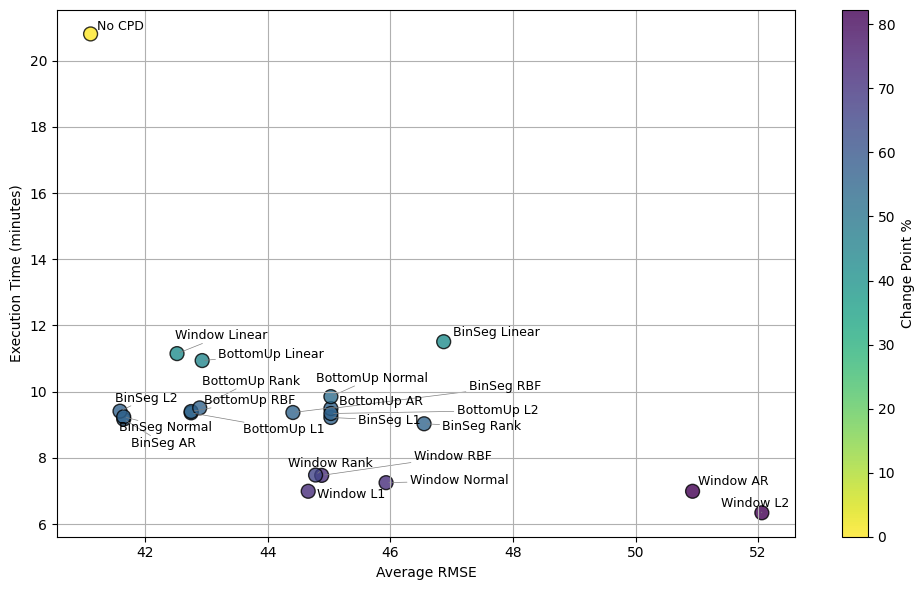

In [74]:
dataset = "UCI_AIR_QUALITY"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.2. [UCI] PM2.5 BEIJING

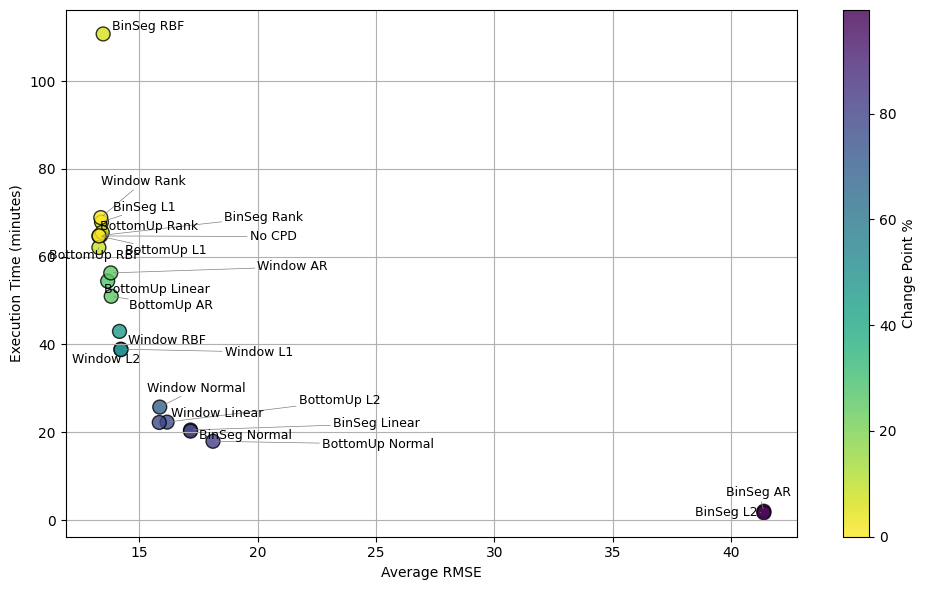

In [75]:
dataset = "UCI_PRSA_BEIJING"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.3. [UCI] Appliances Energy

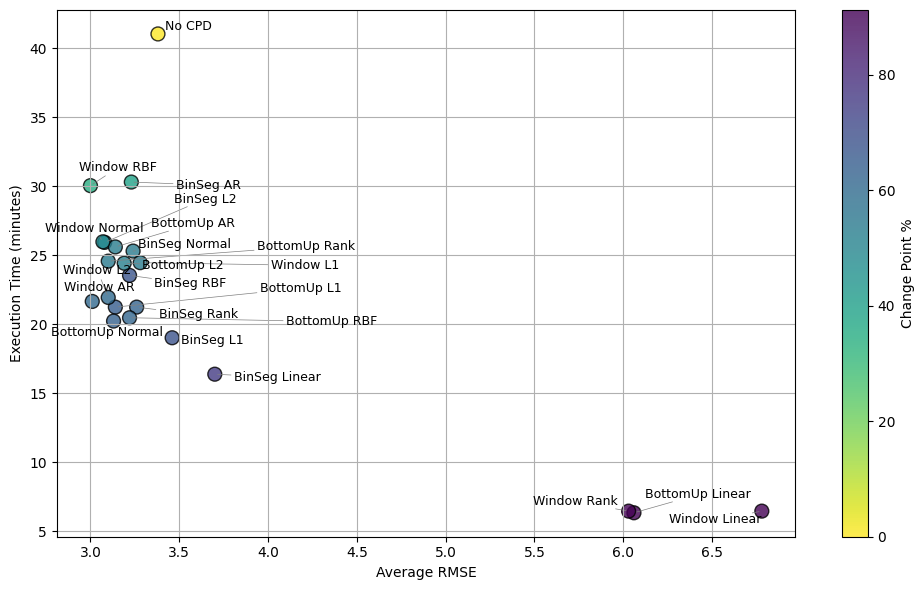

In [76]:
dataset = "UCI_APPLIANCES_ENERGY"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.4. [UCI] Metro Traffic

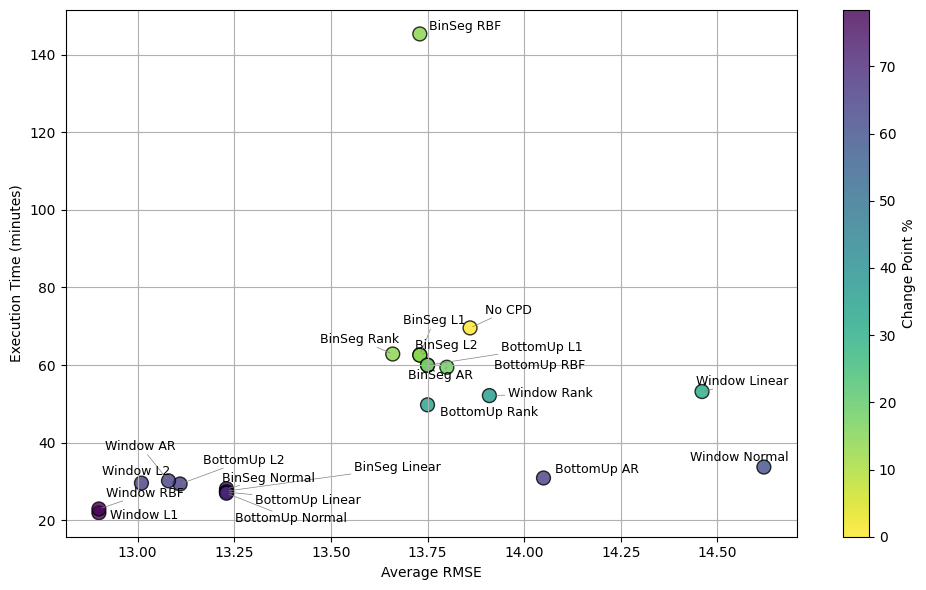

In [77]:
dataset = "UCI_METRO_TRAFFIC"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.5 Combined

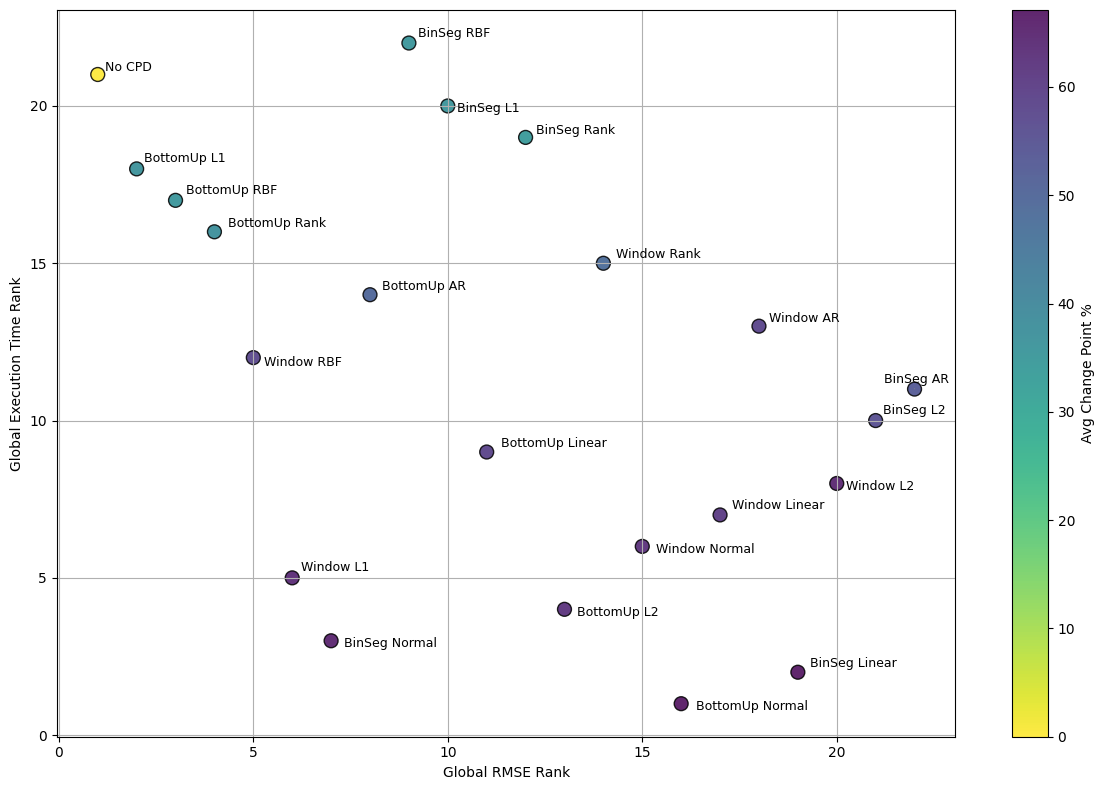

In [78]:
agg_df = comp_df.groupby("change_point_approach").agg({
    f"{RMSE_COL}_mean": "mean",
    f"{ET_MIN_COL}_mean": "mean",
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": "mean"
}).reset_index()

agg_df["RMSE_rank"] = agg_df[f"{RMSE_COL}_mean"].rank(ascending=True)
agg_df["ExecTime_rank"] = agg_df[f"{ET_MIN_COL}_mean"].rank(ascending=True)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    agg_df["RMSE_rank"],
    agg_df["ExecTime_rank"],
    c=agg_df[f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"],
    cmap="viridis_r",
    s=100,
    alpha=0.85,
    edgecolors="k"
)

cbar = plt.colorbar(scatter)
cbar.set_label("Avg Change Point %")

texts = []
for _, row in agg_df.iterrows():
    texts.append(
        plt.text(
            row["RMSE_rank"],
            row["ExecTime_rank"],
            row["change_point_approach"],
            fontsize=9
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.xlabel("Global RMSE Rank")
plt.ylabel("Global Execution Time Rank")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/agg_scatter_plot.png", dpi=300, bbox_inches='tight')
plt.show()